<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230819_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [132]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [133]:
main_figsize=(15,3)

plt.rc('font', size=10)        # 기본 폰트 크기
plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


In [134]:
# Define the Generator
# bucket에 대해 x를 전처리
class Generator(nn.Module):

    def __init__(self,input_dim):
        super(Generator, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [135]:
# Define the Discriminator
# 비즈니스에 해당하는 모델
class Discriminator(nn.Module):

    def __init__(self, input_dim=5):
        """Initializes Discriminator with torch components."""
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [136]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
import scipy

def test_model(model_,model2_, train_tensors, test_tensors, avaible_range,columns):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test

    model_.eval()

    b_dim = XS_test.shape[1]-1

    #test_analysis = {}
    XS = XS_train[:,b_dim].cpu().data.numpy()
    '''
    for bk in np.unique(XS,axis = 0):
        test_analysis[f'Sum(MI{bk})']= []
        test_analysis[f'Std(MI{bk})']= []
        test_analysis[f'Ent(MI{bk})']= []

        test_analysis[f'Sum(DR{bk})']= []
        test_analysis[f'Std(DR{bk})']= []
        test_analysis[f'Ent(DR{bk})']= []

    test_analysis['TrainSum(MI)']= []
    test_analysis['TrainStd(MI)']= []
    test_analysis['TrainEnt(MI)']= []

    test_analysis['Test Sum(MI)']= []
    test_analysis['Test Std(MI)']= []
    test_analysis['Test Ent(MI)']= []

    test_analysis['Test Sum(DR)']= []
    test_analysis['Test Std(DR)']= []
    test_analysis['Test Ent(DR)']= []
    '''
    if model2_ == None:
        ax = XS_test[:,0:b_dim]
        ref_ax = XS_train[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
        ref_ax = model2_(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    ty_ = y_test.data.numpy()
    f1 = f1_score(ty_,y_hat)
    '''
    #################### Test (f(x'),y) #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
    #test_analysis['Test Sum(MI)'].append(np.sum(mi_scores))
    #test_analysis['Test Std(MI)'].append(np.std(mi_scores))
    #test_analysis['Test Ent(MI)'].append(scipy.stats.entropy(mi_scores))

    ks = __ks_drift(ax_df.values,XS_test[:,0:b_dim].cpu().data.numpy())
    #test_analysis['Test Sum(DR)'].append(np.sum(ks[:,0]))
    #test_analysis['Test Std(DR)'].append(np.std(ks[:,0]))
    #test_analysis['Test Ent(DR)'].append(scipy.stats.entropy(ks[:,0]))

    #################### Train (f(x'),y) #########################
    ax_df = pd.DataFrame(ref_ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, y_train.data.numpy(), discrete_features="auto")
    #test_analysis['TrainSum(MI)'].append(np.sum(mi_scores))
    #test_analysis['TrainStd(MI)'].append(np.std(mi_scores))
    #test_analysis['TrainEnt(MI)'].append(scipy.stats.entropy(mi_scores))

    #################### Train (f(x'_b),y_b) #########################
    '''
    '''
    for bk in np.unique(XS,axis = 0):
        inx = np.where(XS==bk)[0]
        #print(XS_train[:,b_dim].cpu().data.numpy())
        if model2_ == None:
            ax = XS_train[inx][:,0:b_dim]
        else:
            ax = model2_(XS_train[inx][:,0:b_dim],XS_train[inx][:,b_dim].reshape(-1,1)/avaible_range)


        ty_ = y_train[inx].data.numpy()

        ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
        mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
        #test_analysis[f'Sum(MI{bk})'].append(np.sum(mi_scores))
        #test_analysis[f'Std(MI{bk})'].append(np.std(mi_scores))
        #test_analysis[f'Ent(MI{bk})'].append(scipy.stats.entropy(mi_scores))

        ks = __ks_drift(XS_train[:,0:b_dim].cpu().data.numpy(),ax_df.values)
        #test_analysis[f'Sum(DR{bk})'].append(np.sum(ks[:,0]))
        #test_analysis[f'Std(DR{bk})'].append(np.std(ks[:,0]))
        #test_analysis[f'Ent(DR{bk})'].append(scipy.stats.entropy(ks[:,0]))
    '''
    print("Test f1 score: {}".format(f1))

    #test_analysis_df = pd.DataFrame(test_analysis)
    #print(test_analysis_df)

    return f1#,test_analysis_df

In [137]:

def test_all_data(discriminator,generator,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break


    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if generator == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = generator(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = discriminator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        #mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), predicted_y, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({test_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [138]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        mi = torch.cat(h, dim=1)
        return mi

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret

        return loss #, ret.sum().reshape(-1,)

In [139]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    #seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    lambda_f = torch.tensor([lambda_f],dtype=torch.float32).to(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []
    m_losses =[]
    f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    discriminator = Discriminator(b_dim).to(device)

    optimizer_G = torch.optim.Adam(discriminator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Generator(b_dim).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(1).to(device)

    mine_loss = customLoss(mine).to(device)
    optimizer_M = torch.optim.Adam(mine_loss.parameters(), lr=0.001)
    #kld_loss = nn.KLDivLoss(reduction='batchmean')
    #default_value = torch.tensor([0.5],dtype=torch.float32).to(device)
    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  x에 대한 predictor
        # -------------------------------

        gen_y = discriminator(XS_train[:,0:b_dim])
        g_loss = bce_loss(gen_y,  y_train.reshape(-1,1))


        if lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------
            m1_loss = mine_loss(XS_train[:,b_dim].reshape(-1,1),y_train.reshape(-1,1)).mean()
            m2_loss = mine_loss(XS_train[:,b_dim].reshape(-1,1),gen_y.reshape(-1,1)).mean()
            a_loss =  m1_loss + torch.abs(m2_loss) * 10


        else:
            a_loss = torch.tensor(0.0)

        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #lambda1 = 0.9

        if lambda_f >= 0.0:
            loss =  g_loss + a_loss
        else:
            loss = g_loss

        loss.backward()

        optimizer_G.step()
        optimizer_M.step()
        #optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        #if lambda_f < 0.0:
        adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1 = test_model(discriminator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Generator loss':a_losses,'Predictor loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    if lambda_f >= 0.0:
        plt.figure(figsize=main_figsize)
        mi_df = pd.DataFrame(m_losses,columns=columns)
        mi_df.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='epoch',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        plt.figure(figsize=main_figsize)
        #plt.plot(a_losses,linewidth=1,label='Adapter loss')
        #plt.plot(g_losses,linewidth=1,label='classifier loss')
        plt.plot(f_losses,linewidth=1,label='lambda')
        plt.ylabel('lambda')
        plt.xlabel('epoch')
        plt.legend(loc=1,ncol=1)
        plt.show()
    '''
    return f1,discriminator,adapter,df_loss

In [140]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [141]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [142]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]

        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            #print(xl.shape)
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    for c_name in df_mis.columns:
        fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
        df_mis[c_name].plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
        ax[0].set_title(f'Mutual Information of {c_name}',fontdict={'fontsize':10})

        df_drf[c_name].plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
        ax[1].set_title(f'Drift (KS-test) of {c_name}',fontdict={'fontsize':10})
        ax[1].legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    df_mis.plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
    ax[0].set_title(f'Mutual Information',fontdict={'fontsize':10})

    df_drf.plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
    ax[1].set_title(f'Drift (KS-test)',fontdict={'fontsize':10})
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return X,Y

In [143]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({test_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [144]:
# importing the modules
from IPython.display import display

def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0,trial_count=20):

    seed_everything()

    print('trial_count:',trial_count)
    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

    lambda_f_set = np.asarray([[-0.1,0.0] for v in range(trial_count)]).reshape(-1,) # np.concatenate([[-0.1 for v in range(trial_count)],[0.0 for v in range(trial_count)]])
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table0 = {} # Original
    result_table1 = {} # Drift tolerant
    # Original
    infos2 = {}
    result_table2 = {}
    result_table2['Trial']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    # Drift tolerant
    infos3 = {}
    result_table3 = {}
    result_table3['Trial']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]


    for idx,lambda_f in enumerate(lambda_f_set):
        if lambda_f < 0.0:

            idx = len(result_table2['test_f1'])
            print(f'######################### Trial {idx} for Normal model ###########################')
        else:
            idx1 = len(result_table3['test_f1']) #idx-int(len(lambda_f_set)/2)
            print(f'######################### Trial {idx1} for Drift tolerant model ###########################')

        f1,last_discriminator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_discriminator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            result_table0[f'T{idx}'] = tad
            result_table2['Trial'].append(idx)

            infos2[f'T{idx}'] = (df_loss,df_mis,df_drf)
            result_table2['test_f1'].append(f1)
            result_table2['init_f1'].append(tad[0])
            result_table2['mean_f1'].append(np.mean(tad))
            result_table2['last_f1'].append(tad[-1])
            '''
            for clm in test_analysis.columns:
                if clm not in result_table2:
                    result_table2[clm] = []
                result_table2[clm].append(test_analysis[clm].values[0])
            '''
        else:
            #idx1 = idx-int(len(lambda_f_set)/2)
            result_table1[f'T{idx1}'] = tad
            result_table3['Trial'].append(idx1)

            infos3[f'T{idx1}'] = (df_loss,df_mis,df_drf)
            result_table3['test_f1'].append(f1)
            result_table3['init_f1'].append(tad[0])
            result_table3['mean_f1'].append(np.mean(tad))
            result_table3['last_f1'].append(tad[-1])
            '''
            for clm in test_analysis.columns:
                if clm not in result_table3:
                    result_table3[clm] = []
                result_table3[clm].append(test_analysis[clm].values[0])
            '''
            print('Normal model mean        :',np.mean(result_table2['mean_f1']))
            print('Drift tolerant model mean:',np.mean(result_table3['mean_f1']))


    Orginal_df = pd.DataFrame(result_table0)
    Driftto_df = pd.DataFrame(result_table1)

    original_statistics_df = pd.DataFrame(result_table2)
    drift_statistics_df = pd.DataFrame(result_table3)

    original_statistics_df.loc[len(original_statistics_df)] = original_statistics_df.mean()
    original_statistics_df.loc[len(original_statistics_df)] = original_statistics_df[0:len(original_statistics_df)-1].sem()
    original_statistics_df.at[len(original_statistics_df)-2,'Trial'] = 'mean'
    original_statistics_df.at[len(original_statistics_df)-1,'Trial'] = 'sem'

    drift_statistics_df.loc[len(drift_statistics_df)] = drift_statistics_df.mean()
    drift_statistics_df.loc[len(drift_statistics_df)] = drift_statistics_df[0:len(drift_statistics_df)-1].sem()
    drift_statistics_df.at[len(drift_statistics_df)-2,'Trial'] = 'mean'
    drift_statistics_df.at[len(drift_statistics_df)-1,'Trial'] = 'sem'

    fig, ax = plt.subplots(figsize=main_figsize)

    Orginal_df.T.plot.box(ax = ax, showfliers=False,ylabel='F1 Score',fontsize=10,color='blue')
    ax.set_xticks([])
    Orginal_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Orginal_df.T.median().values})],axis=0).reset_index(drop=True)
    Orginal_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='blue')

    flierprops = dict(marker='.', markerfacecolor='green', markeredgecolor='none')
    Driftto_df.T.plot.box(ax=ax, flierprops=flierprops,ylabel='F1 Score',fontsize=10,color='green')
    Driftto_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Driftto_df.T.median().values})],axis=0).reset_index(drop=True)
    Driftto_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='green')

    ax.legend(['Normal model','Drift tolerant model'],ncol=2,bbox_to_anchor=(1.0, 1.0))
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('green')

    ax.set_title('Comparison of F1 score between normal model and drift tolerant model',fontdict={'fontsize':10})
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize)

    Orginal_df.T.plot.box(ax = ax, showfliers=False,ylabel='F1 Score',fontsize=10,color='blue')
    ax.set_xticks([])
    Orginal_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Orginal_df.T.median().values})],axis=0).reset_index(drop=True)
    Orginal_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='blue')

    #flierprops = dict(marker='.', markerfacecolor='green', markeredgecolor='none')
    Driftto_df.T.plot.box(ax=ax, showfliers=False,ylabel='F1 Score',fontsize=10,color='green')
    Driftto_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Driftto_df.T.median().values})],axis=0).reset_index(drop=True)
    Driftto_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='green')

    ax.legend(['Normal model','Drift tolerant model'],ncol=2,bbox_to_anchor=(1.0, 1.0))
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('green')

    ax.set_title('Comparison of F1 score between normal model and drift tolerant model without outlier',fontdict={'fontsize':10})
    plt.show()

    max_mean_trial = int(drift_statistics_df[drift_statistics_df['mean_f1']==np.max(drift_statistics_df['mean_f1'])]['Trial'].values[0])
    print('max_mean_trial=',max_mean_trial)

    fig, ax = plt.subplots(figsize=main_figsize)
    Driftto_df[[f'T{max_mean_trial}']].plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='green',label=f'Drift tolerant model (T{max_mean_trial})')
    Orginal_df.T.median().plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='blue',label='Normal model')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_title('Max F1 score of drift tolerant model with normal model median',fontdict={'fontsize':10})
    plt.show()


    og_loss,og_mis,og_drf = infos2['T0']
    df_loss,df_mis,df_drf = infos3[f'T{max_mean_trial}']

    ax = df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket')
    ax.set_title(f'Training loss at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize, nrows=1, ncols=2)
    og_mis.astype(np.float32).plot(ax = ax[0],linewidth=1,ylabel='MI',xlabel='bucket',legend=None)
    ax[0].set_title(f'MI of original feature',fontdict={'fontsize':10})
    df_mis.astype(np.float32).plot(ax = ax[1],linewidth=1,ylabel='MI',xlabel='bucket')
    ax[1].set_title(f'MI with predicted y at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    '''
    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    og_drf.astype(np.float32).plot(ax=ax[0],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',legend=None)
    ax[0].set_title(f'Drift of original feature',fontdict={'fontsize':10})
    df_drf.astype(np.float32).plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket')
    ax[1].set_title(f'Drift of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    '''
    display(original_statistics_df)

    display(drift_statistics_df)

    return Orginal_df, Driftto_df, infos2, infos3, original_statistics_df,drift_statistics_df

# 이론

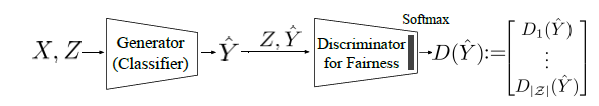

+ "FR-Train" 에서, discriminator의 loss를 정의하기 위해 아래와 같이 유도 했었다.

+ The discriminator for fairness in FR-Train distinguishes predictions w.r.t. one sensitive group from those in the others.
+ Disparate impact intends the sensitive attribute to be independent of the model’s prediction, i.e., $I(Z;\hat{Y}) = 0$.

+ 여기서, $I(Z;\hat{Y}) = 0$ sensitive group Z가 Y^와 독립적이여햐 한다는 것이고, 내가 의도하는 importance (=sensitive)의 변화는 train dataset을 단위 기간 순서로 자른 N개의 Bucket 또는 어떤 시간 단위 순서의 조건에 대해 독립이여야 한다는 것.

+ 따라서,  N개의 bucket을 B라고 한다면, conditional mutual importance $I(Z;\hat{Y}|B) = 0$ 가 되어야 한다.
+ 또한, FR-Train 이나 상기 논문 "Mitigating Unwanted Biases with Adversarial Learning"과 본 연구의 큰 차이점은 인구통계학적인 Disparate impact, 즉 남/여, 흑인/백인의 직접적인 fairness를 다루는 것이 아닌, continous한 z,y의 변화하는 sensitiveness를 다루는 것이다.

+ 실험1은 MI를 직접 다루지 않고 대신 mse로 대체하여 코드를 구현했으므로 논리적인 비약이 있다고 본다.
+ 따라서, MI를 직접 최대화, 최소화 할 수 있는 방안으로 코드를 구현하여 실험해 본다.
+ 이때, MI는 학습에 의해 최적화 시켜야 하므로 MINE (Mutual Information Neural Estimation)를 적용한다.
+ 상기 실험1과 유사하여 I(y,z)은 최대화 하고 I(y^,z)은 최소화 되도록 한다.

## RF-Train 에서 도출한 loss function

 + For the loss function of the generator, we employ cross entropy:

$$
\begin{align}
L_1= \dfrac{1}{m} \sum_{i=1}^{m} -y^{(i)} log \hat{y}^{(i)} - (1 - y^{(i)})log(1-\hat{y}^{(i)})
\end{align}
\tag{7}
$$
$$
\hat{I(\hat{Y},Z)} = \sup_{\theta \in \Theta} \mathbb{E}_{\mathbb{P}(n)_{\hat{Y}Z}}[T_{\theta}] - log(\mathbb{E}_{\mathbb{P}(n)_{\hat{Y}}\otimes \mathbb{\hat{P}}(n)_{Z}}[e^{T_{\theta}}] )
\tag{8}
$$

$$
L_2 = -I(Y,Z) + I(\hat{Y},Z)
\tag{9}
$$
여기서, $I$는 $\hat{I}를 의미한다. $
$$
\begin{align}
\min_{G(.)} (1-λ)L_1 + λ L_2
\end{align}
\tag{10}
$$

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [145]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [146]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [147]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


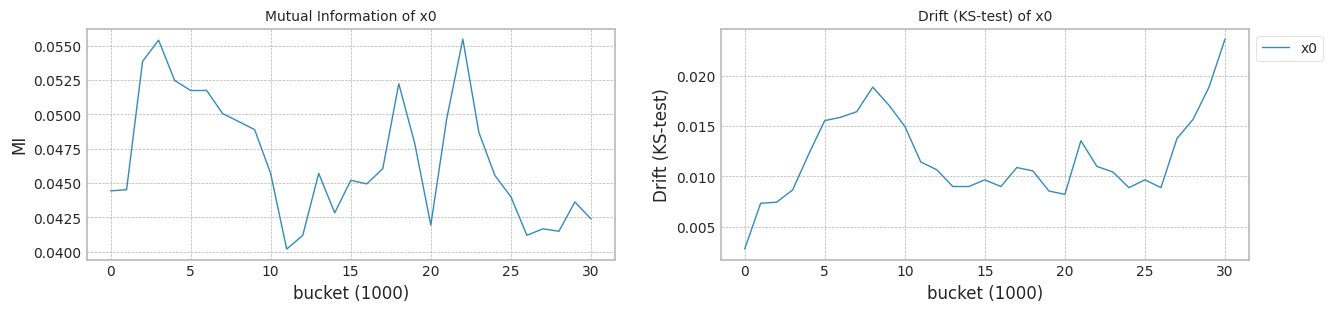

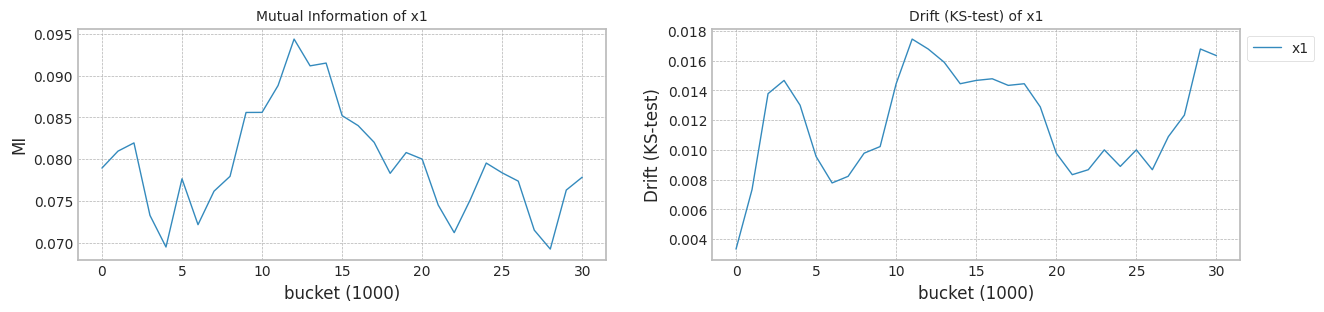

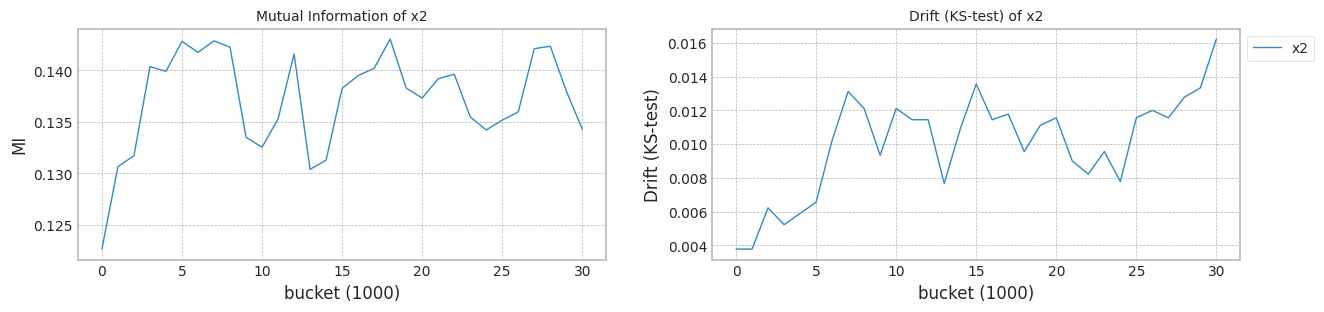

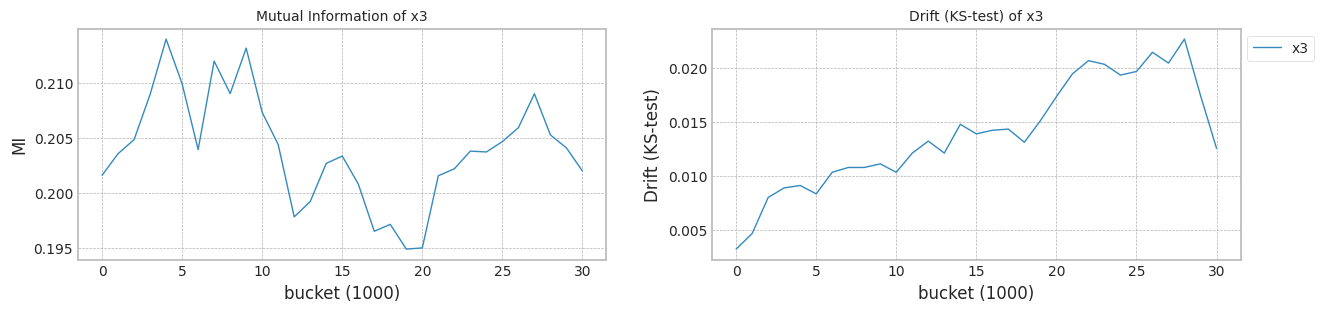

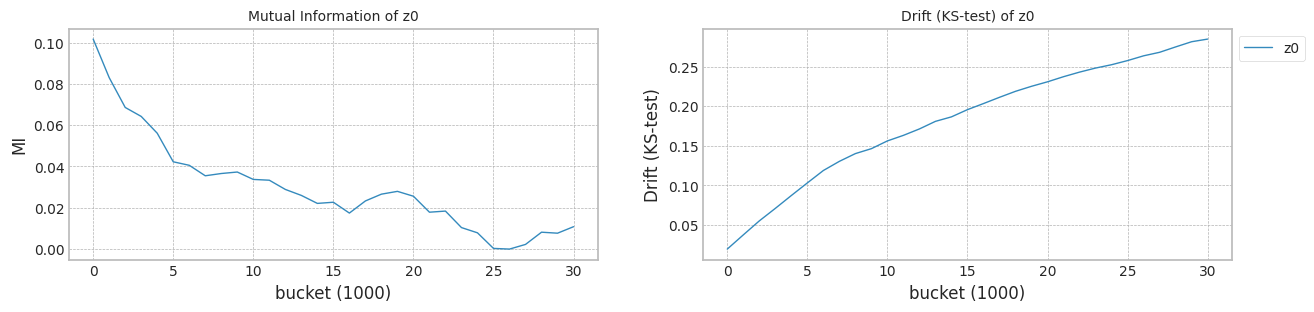

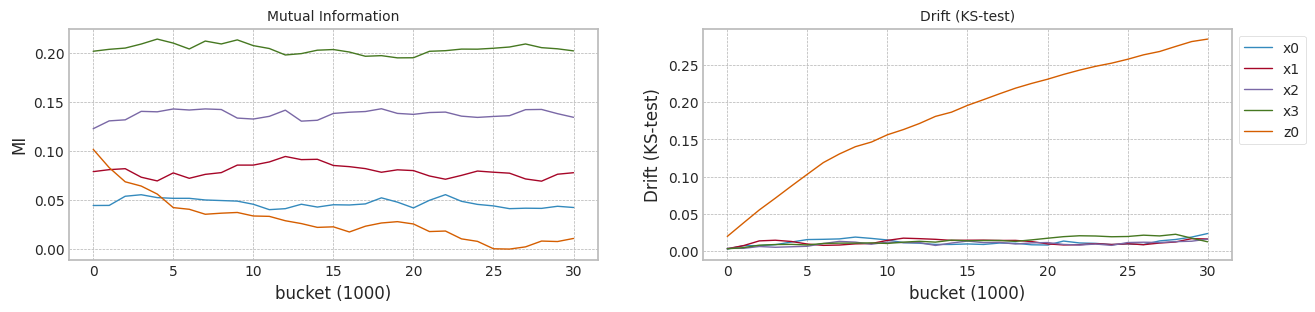

In [148]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

cpu


100%|██████████| 300/300 [00:12<00:00, 24.99it/s]


<Axes: >

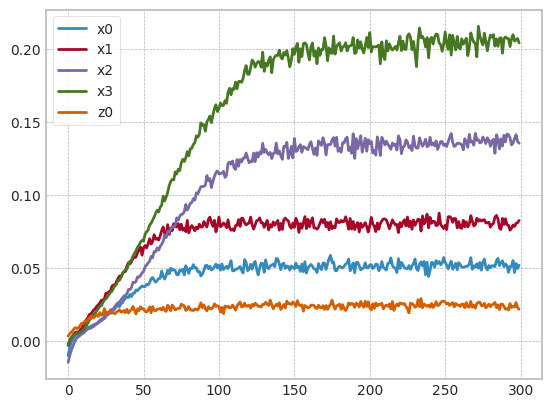

In [149]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mine = Net(X1.shape[1]).to(device)
loss_mse = customLoss(mine).to(device)
optimizer = torch.optim.Adam(loss_mse.parameters(), lr=0.01)
plot_loss = []

x = torch.tensor(X1.values,dtype=torch.float32).to(device)
y = torch.tensor(Y1,dtype=torch.float32).to(device)

for epoch in tqdm(range(300)):
    mine.zero_grad()
    mine_loss = loss_mse(x,y)
    mine_loss.sum().backward()
    optimizer.step()
    plot_loss.append(-mine_loss.cpu().data.numpy())

plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=X1.columns)

df_loss.plot()

In [150]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.421766   0
1      0.447230  0.556479  0.629077  0.735705  0.529014   0
2      0.489501  0.704159  0.760582  0.582973  0.570549   0
3      0.581446  0.301839  0.443337  0.515173  0.396001   0
4      0.571642  0.639275  0.524701  0.583380  0.561748   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.185740  39
39996  0.426322  0.302644  0.484909  0.587518  0.721101  39
39997  0.374186  0.587769  0.624447  0.598315  0.489479  39
39998  0.470439  0.265430  0.218971  0.645349  1.258888  39
39999  0.654583  0.419378  0.800216  0.614031  1.055564  39

[40000 rows x 6 columns]

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 256.25it/s]


Test f1 score: 0.8763676148796499
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.49it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7999359745907817
######################### Trial 0 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:52<00:00, 76.58it/s]


Test f1 score: 0.8713860544217686
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.59it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.809251466212018
Normal model mean        : 0.7999359745907817
Drift tolerant model mean: 0.809251466212018
######################### Trial 1 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 260.71it/s]


Test f1 score: 0.8751501911523758
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.799851351335031
######################### Trial 1 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:52<00:00, 76.08it/s]


Test f1 score: 0.8749179969385525
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.31it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8024591237045999
Normal model mean        : 0.7998936629629063
Drift tolerant model mean: 0.805855294958309
######################### Trial 2 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 256.38it/s]


Test f1 score: 0.8763258611262985
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8010300421112816
######################### Trial 2 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:52<00:00, 76.34it/s]


Test f1 score: 0.8184615384615384
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.50it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7663785143703985
Normal model mean        : 0.8002724560123647
Drift tolerant model mean: 0.7926963680956721
######################### Trial 3 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 276.11it/s]


Test f1 score: 0.844030118321979
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.47it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7813333585207795
######################### Trial 3 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:47<00:00, 83.82it/s]


Test f1 score: 0.876088850174216
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8226404400842734
Normal model mean        : 0.7955376816394684
Drift tolerant model mean: 0.8001823860928224
######################### Trial 4 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 290.00it/s]


Test f1 score: 0.8766915665259284
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8051625388642469
######################### Trial 4 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:46<00:00, 86.21it/s]


Test f1 score: 0.876165690739536
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8077091626939837
Normal model mean        : 0.797462653084424
Drift tolerant model mean: 0.8016877414130548
######################### Trial 5 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 282.76it/s]


Test f1 score: 0.8745777487196251
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7973937916636948
######################### Trial 5 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:45<00:00, 87.63it/s]


Test f1 score: 0.8761633636264098
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7967522935982951
Normal model mean        : 0.7974511761809692
Drift tolerant model mean: 0.8008651667772616
######################### Trial 6 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 290.94it/s]


Test f1 score: 0.829709121717029
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.50it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7894915684054854
######################### Trial 6 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:45<00:00, 87.96it/s]


Test f1 score: 0.8735463593504452
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8037707934136821
Normal model mean        : 0.7963140893559001
Drift tolerant model mean: 0.8012802562967503
######################### Trial 7 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 291.52it/s]


Test f1 score: 0.6685405725275537
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.81it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.6665410430947298
######################### Trial 7 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 88.91it/s]


Test f1 score: 0.8468838665492613
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8077263084899285
Normal model mean        : 0.7800924585732538
Drift tolerant model mean: 0.8020860128208974
######################### Trial 8 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 298.26it/s]


Test f1 score: 0.8756436945327052
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.797285301038135
######################### Trial 8 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.11it/s]


Test f1 score: 0.875438596491228
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.63it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8017988032006523
Normal model mean        : 0.7820027744026851
Drift tolerant model mean: 0.8020541006408702
######################### Trial 9 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 302.76it/s]


Test f1 score: 0.8751222693185524
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.804471977163491
######################### Trial 9 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:43<00:00, 91.05it/s]


Test f1 score: 0.876465479808945
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8114284202469736
Normal model mean        : 0.7842496946787657
Drift tolerant model mean: 0.8029915326014805
######################### Trial 10 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 299.01it/s]


Test f1 score: 0.876215448486835
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8048499402433007
######################### Trial 10 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:43<00:00, 91.16it/s]


Test f1 score: 0.8760026013440277
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8018894777966407
Normal model mean        : 0.7861224442755416
Drift tolerant model mean: 0.8028913458010405
######################### Trial 11 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 294.49it/s]


Test f1 score: 0.8651685393258428
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7956595432183685
######################### Trial 11 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 89.23it/s]


Test f1 score: 0.8771089583106564
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8037507602039732
Normal model mean        : 0.7869172025207772
Drift tolerant model mean: 0.8029629636679516
######################### Trial 12 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 302.27it/s]


Test f1 score: 0.8756240503581507
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8042912401514216
######################### Trial 12 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:43<00:00, 92.65it/s]


Test f1 score: 0.843010752688172
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.56it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7754018022262672
Normal model mean        : 0.7882536669539036
Drift tolerant model mean: 0.8008428743262835
######################### Trial 13 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 299.40it/s]


Test f1 score: 0.8586497890295358
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.63it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7753031030933591
######################### Trial 13 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.81it/s]


Test f1 score: 0.8755871108683779
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7994959544051409
Normal model mean        : 0.7873286266781505
Drift tolerant model mean: 0.8007466657604876
######################### Trial 14 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 302.24it/s]


Test f1 score: 0.8757499727282645
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7996780204301254
######################### Trial 14 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 89.61it/s]


Test f1 score: 0.8658523164960933
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8289004281687233
Normal model mean        : 0.7881519195949488
Drift tolerant model mean: 0.8026235832543699
######################### Trial 15 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 299.55it/s]


Test f1 score: 0.8742124701281773
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8047296688275116
######################### Trial 15 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.62it/s]


Test f1 score: 0.8738287208542166
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8073169384516796
Normal model mean        : 0.789188028921984
Drift tolerant model mean: 0.802916917954202
######################### Trial 16 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 297.25it/s]


Test f1 score: 0.8663178413870936
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8072935016452077
######################### Trial 16 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 89.74it/s]


Test f1 score: 0.8713550600343054
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8153252988227314
Normal model mean        : 0.7902530567292325
Drift tolerant model mean: 0.8036468227111743
######################### Trial 17 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 295.94it/s]


Test f1 score: 0.8685808377071113
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8036465047380564
######################### Trial 17 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:43<00:00, 92.07it/s]


Test f1 score: 0.8773429792831305
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7973160447861879
Normal model mean        : 0.7909971371741672
Drift tolerant model mean: 0.8032951128264528
######################### Trial 18 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 302.80it/s]


Test f1 score: 0.8755720200479408
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.801685955333414
######################### Trial 18 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 89.52it/s]


Test f1 score: 0.8763604701784937
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8040152506833403
Normal model mean        : 0.7915597065509696
Drift tolerant model mean: 0.8033330148189206
######################### Trial 19 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 303.63it/s]


Test f1 score: 0.8754518567203418
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.8023235754931841
######################### Trial 19 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.06it/s]


Test f1 score: 0.87546346782988
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7999672403235805
Normal model mean        : 0.7920978999980803
Drift tolerant model mean: 0.8031647260941537


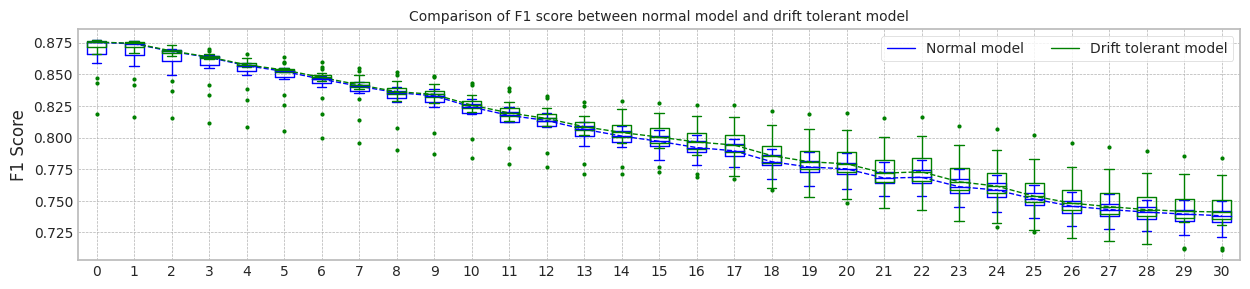

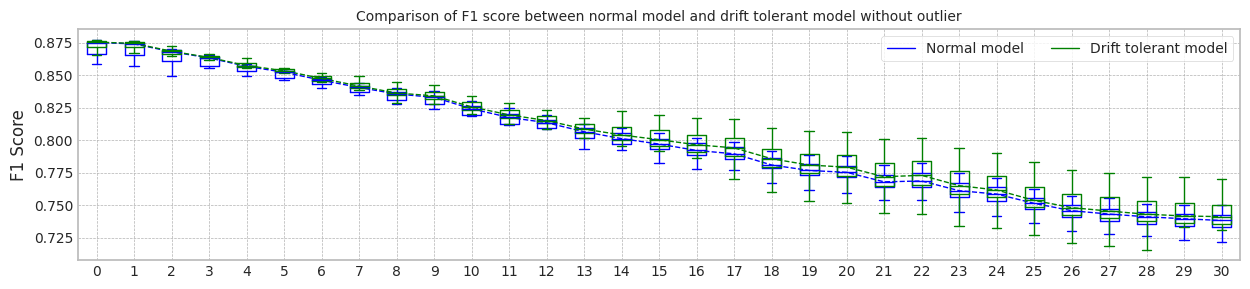

max_mean_trial= 14


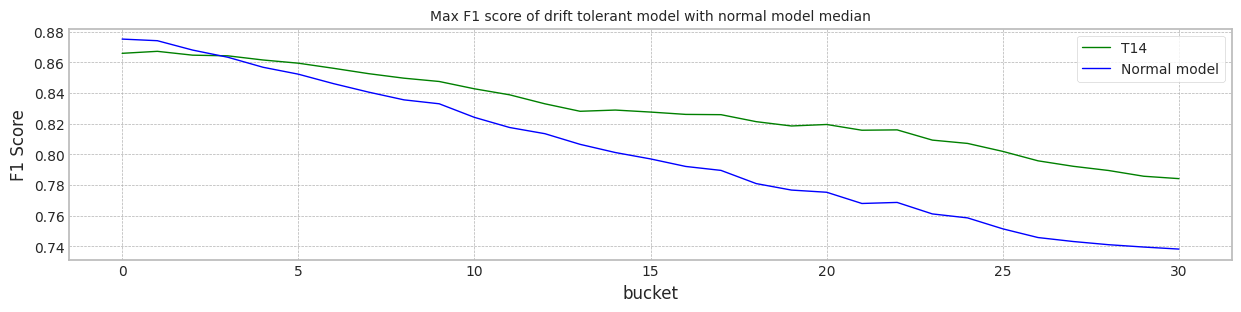

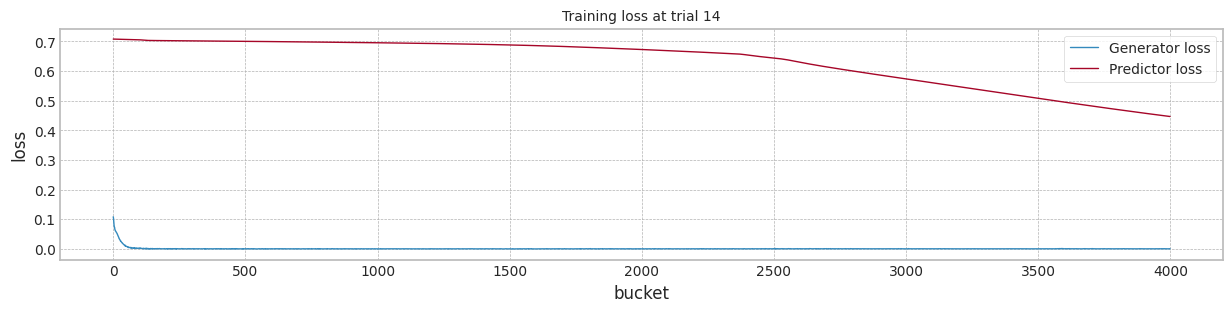

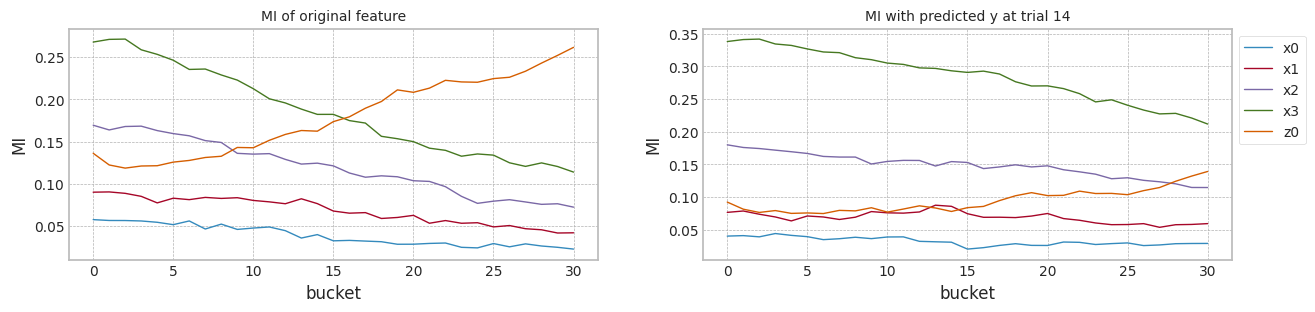

Trial   test_f1   init_f1   mean_f1   last_f1
0    0.0  0.876368  0.876368  0.799936  0.733370
1    1.0  0.875150  0.875150  0.799851  0.735849
2    2.0  0.876326  0.876326  0.801030  0.738106
3    3.0  0.844030  0.844030  0.781333  0.721419
4    4.0  0.876692  0.876692  0.805163  0.741842
5    5.0  0.874578  0.874578  0.797394  0.733081
6    6.0  0.829709  0.829709  0.789492  0.749761
7    7.0  0.668541  0.668541  0.666541  0.674228
8    8.0  0.875644  0.875644  0.797285  0.732462
9    9.0  0.875122  0.875122  0.804472  0.742142
10  10.0  0.876215  0.876215  0.804850  0.741953
11  11.0  0.865169  0.865169  0.795660  0.729101
12  12.0  0.875624  0.875624  0.804291  0.742333
13  13.0  0.858650  0.858650  0.775303  0.703985
14  14.0  0.875750  0.875750  0.799678  0.735052
15  15.0  0.874212  0.874212  0.804730  0.742226
16  16.0  0.866318  0.866318  0.807294  0.749411
17  17.0  0.868581  0.868581  0.803647  0.743063
18  18.0  0.875572  0.875572  0.801686  0.738928
19  19.0  0.875452  0.875452  0.802324  0.738341
20  mean  0.859185  0.859185  0.792098  0.733333
21   sem  0.010403  0.010403  0.006854  0.003843

Trial   test_f1   init_f1   mean_f1   last_f1
0    0.0  0.871386  0.871386  0.809251  0.750505
1    1.0  0.874918  0.874918  0.802459  0.739366
2    2.0  0.818462  0.818462  0.766379  0.712966
3    3.0  0.876089  0.876089  0.822640  0.767722
4    4.0  0.876166  0.876166  0.807709  0.747027
5    5.0  0.876163  0.876163  0.796752  0.731255
6    6.0  0.873546  0.873546  0.803771  0.741766
7    7.0  0.846884  0.846884  0.807726  0.770073
8    8.0  0.875439  0.875439  0.801799  0.737942
9    9.0  0.876465  0.876465  0.811428  0.750431
10  10.0  0.876003  0.876003  0.801889  0.738329
11  11.0  0.877109  0.877109  0.803751  0.740564
12  12.0  0.843011  0.843011  0.775402  0.711455
13  13.0  0.875587  0.875587  0.799496  0.734876
14  14.0  0.865852  0.865852  0.828900  0.784151
15  15.0  0.873829  0.873829  0.807317  0.746473
16  16.0  0.871355  0.871355  0.815325  0.759945
17  17.0  0.877343  0.877343  0.797316  0.731713
18  18.0  0.876360  0.876360  0.804015  0.741897
19  19.0  0.875463  0.875463  0.799967  0.735804
20  mean  0.868872  0.868872  0.803165  0.743713
21   sem  0.003400  0.003400  0.003070  0.003908

In [151]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [152]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [153]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [154]:
x1.shape

(40000, 5)

In [155]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

In [156]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


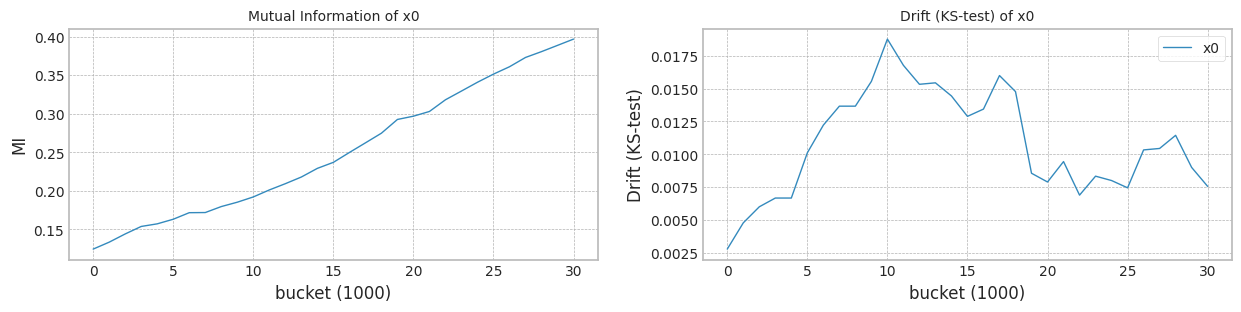

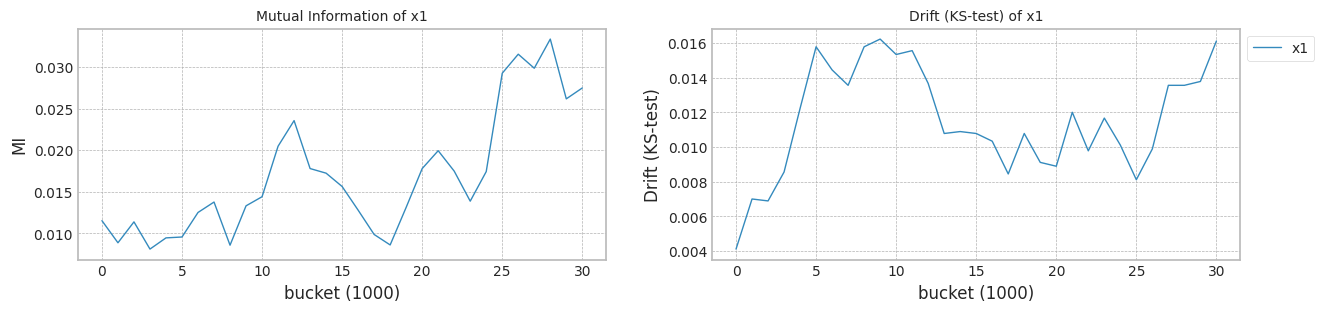

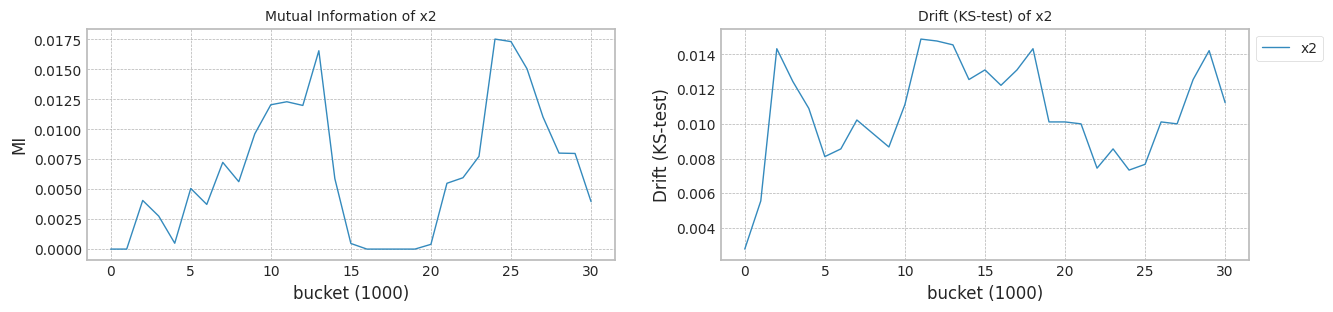

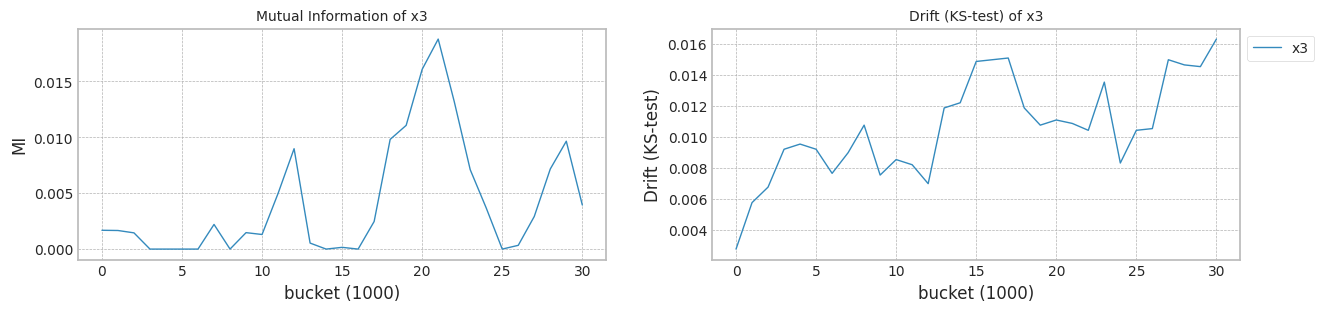

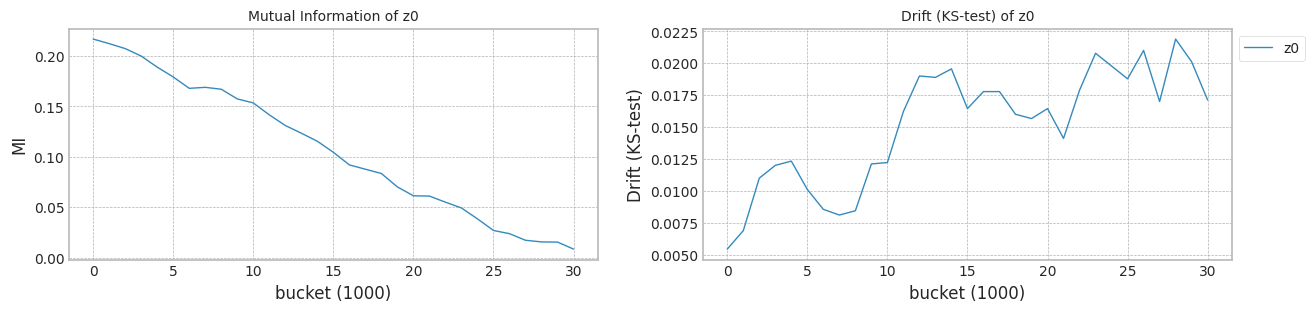

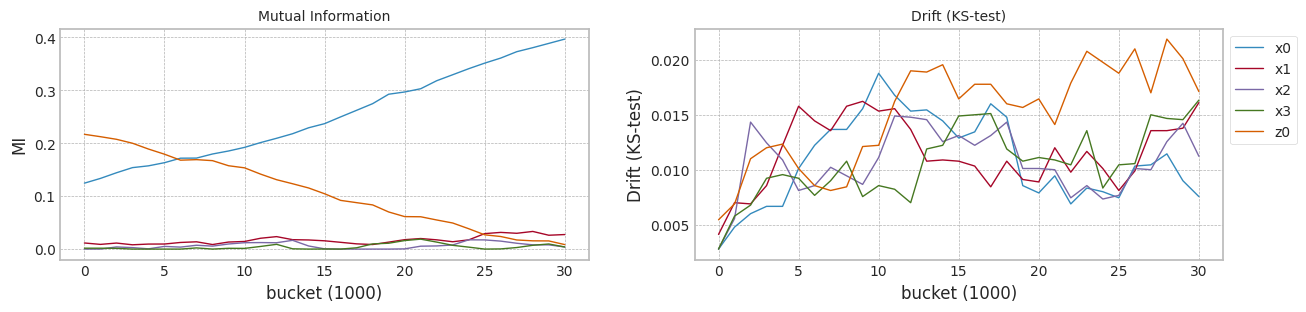

In [157]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [158]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.366139   0
1      0.610533  0.420412  0.508390  0.580336  0.662926   0
2      0.556874  0.464734  0.669603  0.724770  0.486574   0
3      0.344341  0.646524  0.340976  0.528780  0.611850   0
4      0.503142  0.550860  0.598773  0.465698  0.487044   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.709407  39
39996  0.358451  0.483875  0.341855  0.574439  0.695384  39
39997  0.559469  0.343824  0.542547  0.575250  0.504288  39
39998  0.433692  0.530132  0.301231  0.282353  0.762158  39
39999  0.538629  0.637825  0.358726  0.768301  0.522435  39

[40000 rows x 6 columns]

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:22<00:00, 177.71it/s]


Test f1 score: 0.9662005741272339
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.33it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8790432735532113
######################### Trial 0 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:21<00:00, 48.98it/s]


Test f1 score: 0.9519408502772643
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.32it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8786015691301139
Normal model mean        : 0.8790432735532113
Drift tolerant model mean: 0.8786015691301139
######################### Trial 1 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:21<00:00, 189.94it/s]


Test f1 score: 0.9439706556625401
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.34it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8752042641980794
######################### Trial 1 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:20<00:00, 49.88it/s]


Test f1 score: 0.9312670920692798
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.33it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8626979536496471
Normal model mean        : 0.8771237688756454
Drift tolerant model mean: 0.8706497613898805
######################### Trial 2 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:20<00:00, 198.88it/s]


Test f1 score: 0.9672450589217778
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8869018501981776
######################### Trial 2 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:19<00:00, 50.04it/s]


Test f1 score: 0.8917599186164802
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.50it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8345614542830065
Normal model mean        : 0.8803831293164895
Drift tolerant model mean: 0.8586203256875892
######################### Trial 3 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:19<00:00, 209.49it/s]


Test f1 score: 0.9223582173222461
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.37it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.852587515112032
######################### Trial 3 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:18<00:00, 51.23it/s]


Test f1 score: 0.9311617025105732
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8781190916558189
Normal model mean        : 0.8734342257653751
Drift tolerant model mean: 0.8634950171796466
######################### Trial 4 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:19<00:00, 210.42it/s]


Test f1 score: 0.9020316804407713
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.46it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8394906459097428
######################### Trial 4 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:17<00:00, 51.83it/s]


Test f1 score: 0.9322723573559997
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.47it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8635894801464711
Normal model mean        : 0.8666455097942487
Drift tolerant model mean: 0.8635139097730115
######################### Trial 5 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:18<00:00, 217.59it/s]


Test f1 score: 0.9394240317775571
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8671726230644158
######################### Trial 5 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:11<00:00, 55.84it/s]


Test f1 score: 0.9529953917050691
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8713335770292953
Normal model mean        : 0.8667333620059433
Drift tolerant model mean: 0.8648171876490588
######################### Trial 6 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:17<00:00, 225.36it/s]


Test f1 score: 0.8614477563052734
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8109650220556328
######################### Trial 6 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:02<00:00, 63.81it/s]


Test f1 score: 0.9511727662681392
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8739540347179383
Normal model mean        : 0.858766456298756
Drift tolerant model mean: 0.8661224515160415
######################### Trial 7 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 240.67it/s]


Test f1 score: 0.8673427322945008
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8155606429713964
######################### Trial 7 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:56<00:00, 70.42it/s]


Test f1 score: 0.8249430613366842
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.35it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7736948468307585
Normal model mean        : 0.8533657296328361
Drift tolerant model mean: 0.8545690009303812
######################### Trial 8 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 259.45it/s]


Test f1 score: 0.9658826810449008
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8892073226847788
######################### Trial 8 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:53<00:00, 74.83it/s]


Test f1 score: 0.9358986049056259
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.50it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8807629857966881
Normal model mean        : 0.8573481288608298
Drift tolerant model mean: 0.8574794436933042
######################### Trial 9 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 268.52it/s]


Test f1 score: 0.9359641911025852
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8727307289888034
######################### Trial 9 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:49<00:00, 80.54it/s]


Test f1 score: 0.9311219865869133
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.49it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8728128184922029
Normal model mean        : 0.8588863888736272
Drift tolerant model mean: 0.8590127811731941
######################### Trial 10 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 268.48it/s]


Test f1 score: 0.9267160581986968
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8676362255861775
######################### Trial 10 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:47<00:00, 83.94it/s]


Test f1 score: 0.960931768158474
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8857903339538067
Normal model mean        : 0.8596818285747682
Drift tolerant model mean: 0.8614471041532498
######################### Trial 11 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 287.30it/s]


Test f1 score: 0.9351400180668473
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.49it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8878862400215796
######################### Trial 11 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:46<00:00, 86.93it/s]


Test f1 score: 0.9064709567707867
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.46it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8374082996411575
Normal model mean        : 0.8620321961953358
Drift tolerant model mean: 0.8594438704439088
######################### Trial 12 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 287.81it/s]


Test f1 score: 0.9621344090950765
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8855583261011961
######################### Trial 12 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:46<00:00, 86.92it/s]


Test f1 score: 0.9311518819746548
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.85023398044856
Normal model mean        : 0.8638418984957865
Drift tolerant model mean: 0.8587354173673436
######################### Trial 13 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 297.21it/s]


Test f1 score: 0.9283825025432351
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8698608818608892
######################### Trial 13 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 89.01it/s]


Test f1 score: 0.9491463190747201
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.51it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8788445226685052
Normal model mean        : 0.8642718258790082
Drift tolerant model mean: 0.8601717820317123
######################### Trial 14 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 289.21it/s]


Test f1 score: 0.958760033213396
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8849456553498859
######################### Trial 14 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.75it/s]


Test f1 score: 0.9146200904335491
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.50it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8621129119239991
Normal model mean        : 0.8656500811770668
Drift tolerant model mean: 0.860301190691198
######################### Trial 15 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 296.20it/s]


Test f1 score: 0.9280633834518771
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8605557149273428
######################### Trial 15 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.30it/s]


Test f1 score: 0.9400347889773871
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.51it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8626046550938191
Normal model mean        : 0.8653316832864588
Drift tolerant model mean: 0.8604451572163618
######################### Trial 16 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 303.63it/s]


Test f1 score: 0.9169863969305894
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.51it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8539571122472162
######################### Trial 16 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 89.51it/s]


Test f1 score: 0.9070138150903294
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8583128783123546
Normal model mean        : 0.8646625908723857
Drift tolerant model mean: 0.8603197290455379
######################### Trial 17 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 297.13it/s]


Test f1 score: 0.9488423171959367
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.50it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8784568381050208
######################### Trial 17 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.68it/s]


Test f1 score: 0.9603768356885564
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.49it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8794786948968942
Normal model mean        : 0.8654289379408654
Drift tolerant model mean: 0.8613841160372799
######################### Trial 18 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 301.96it/s]


Test f1 score: 0.9418775210854418
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8644777543411268
######################### Trial 18 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.31it/s]


Test f1 score: 0.9321438226547716
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.51it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8668384358600594
Normal model mean        : 0.8653788756461424
Drift tolerant model mean: 0.8616711855016367
######################### Trial 19 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 298.31it/s]


Test f1 score: 0.9476956839795172
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8913634537177832
######################### Trial 19 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.16it/s]


Test f1 score: 0.9710521432547782
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.896494122518549
Normal model mean        : 0.8666781045497244
Drift tolerant model mean: 0.8634123323524824


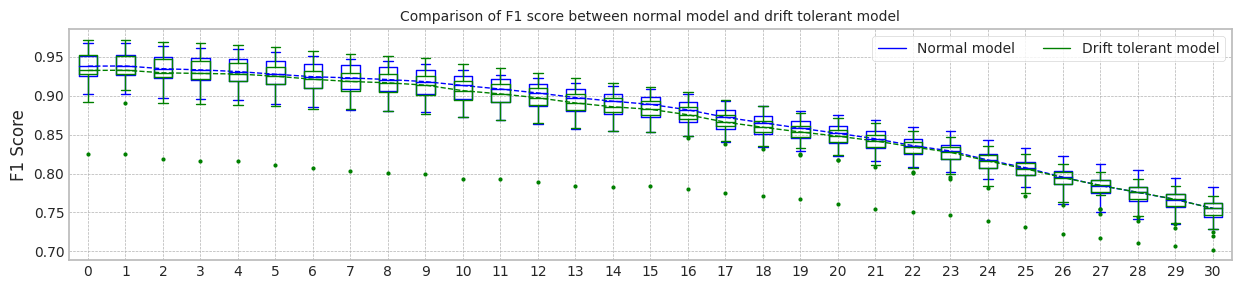

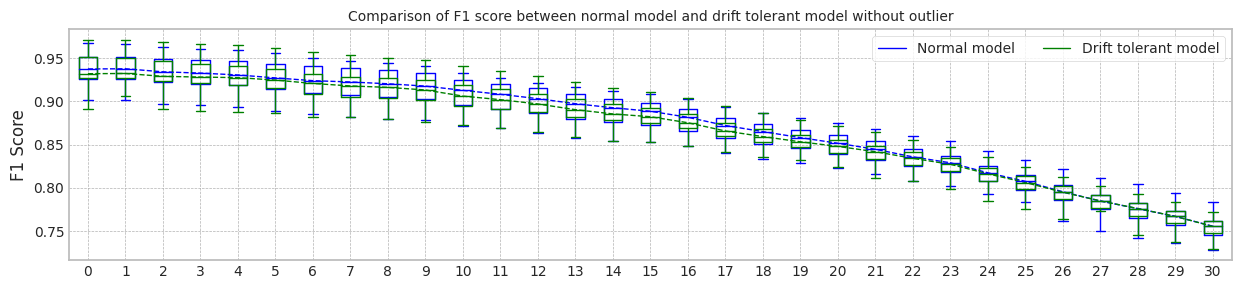

max_mean_trial= 19


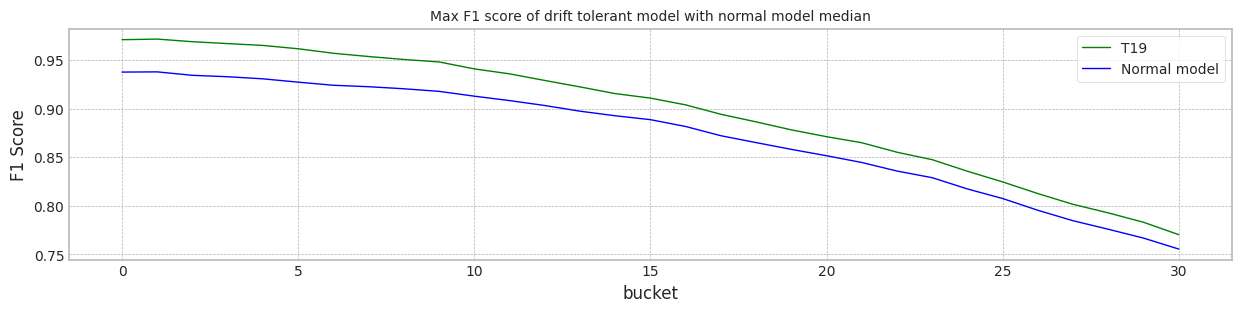

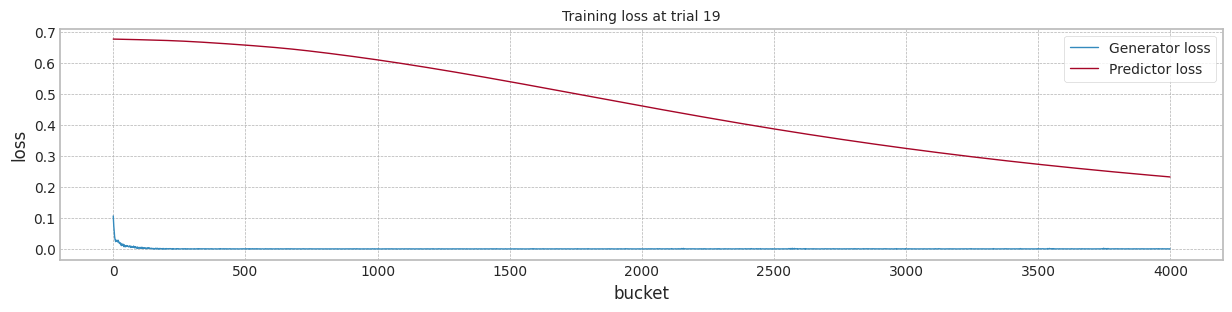

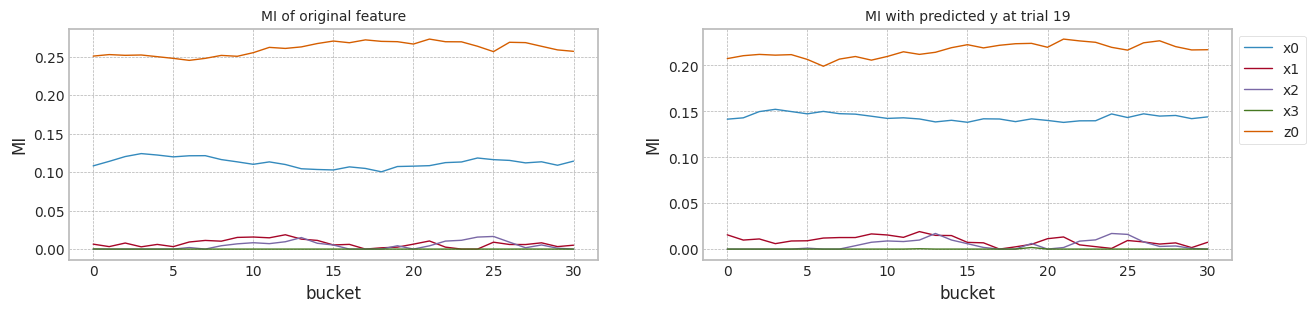

Trial   test_f1   init_f1   mean_f1   last_f1
0    0.0  0.966201  0.966201  0.879043  0.750255
1    1.0  0.943971  0.943971  0.875204  0.758991
2    2.0  0.967245  0.967245  0.886902  0.761183
3    3.0  0.922358  0.922358  0.852588  0.736330
4    4.0  0.902032  0.902032  0.839491  0.737291
5    5.0  0.939424  0.939424  0.867173  0.751742
6    6.0  0.861448  0.861448  0.810965  0.728232
7    7.0  0.867343  0.867343  0.815561  0.731461
8    8.0  0.965883  0.965883  0.889207  0.764374
9    9.0  0.935964  0.935964  0.872731  0.761463
10  10.0  0.926716  0.926716  0.867636  0.761071
11  11.0  0.935140  0.935140  0.887886  0.782947
12  12.0  0.962134  0.962134  0.885558  0.762878
13  13.0  0.928383  0.928383  0.869861  0.743543
14  14.0  0.958760  0.958760  0.884946  0.762758
15  15.0  0.928063  0.928063  0.860556  0.749257
16  16.0  0.916986  0.916986  0.853957  0.749832
17  17.0  0.948842  0.948842  0.878457  0.760142
18  18.0  0.941878  0.941878  0.864478  0.745158
19  19.0  0.947696  0.947696  0.891363  0.779360
20  mean  0.933323  0.933323  0.866678  0.753913
21   sem  0.006576  0.006576  0.005114  0.003234

Trial   test_f1   init_f1   mean_f1   last_f1
0    0.0  0.951941  0.951941  0.878602  0.759212
1    1.0  0.931267  0.931267  0.862698  0.749723
2    2.0  0.891760  0.891760  0.834561  0.719224
3    3.0  0.931162  0.931162  0.878119  0.771794
4    4.0  0.932272  0.932272  0.863589  0.751695
5    5.0  0.952995  0.952995  0.871334  0.747986
6    6.0  0.951173  0.951173  0.873954  0.753155
7    7.0  0.824943  0.824943  0.773695  0.702361
8    8.0  0.935899  0.935899  0.880763  0.771009
9    9.0  0.931122  0.931122  0.872813  0.764229
10  10.0  0.960932  0.960932  0.885790  0.764093
11  11.0  0.906471  0.906471  0.837408  0.728944
12  12.0  0.931152  0.931152  0.850234  0.725328
13  13.0  0.949146  0.949146  0.878845  0.760706
14  14.0  0.914620  0.914620  0.862113  0.760712
15  15.0  0.940035  0.940035  0.862605  0.744567
16  16.0  0.907014  0.907014  0.858313  0.759664
17  17.0  0.960377  0.960377  0.879479  0.755048
18  18.0  0.932144  0.932144  0.866838  0.755197
19  19.0  0.971052  0.971052  0.896494  0.770191
20  mean  0.930374  0.930374  0.863412  0.750742
21   sem  0.007137  0.007137  0.005821  0.004132

In [159]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

In [160]:
import matplotlib.pyplot as plt

cor = np.asarray([2.5, 1.2, 0.9 , 0.7, 1.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

seed_everything()

y1_array = []
cor_const = cor[0]
for ii in range(x1.shape[0]):
    cor[0] = cor[0] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    e1 = np.random.normal(0.0,  4*ii/40000)
    x1[ii,4] = x1[ii,4] + e1
    y1_array.append(np.sum(cor * x1[ii])+e)

In [161]:
m = np.mean(y1_array)
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
sum(y1)

5.568336092094251


19898

### 실험

MI Analysis MI Max 0.18765, Min 0.00339, Mean 0.06075, Std 0.07062
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:06<00:00,  4.59it/s]


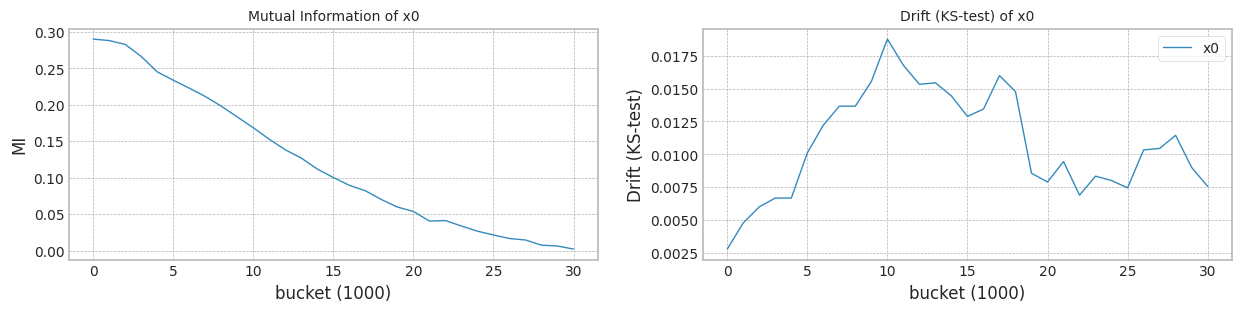

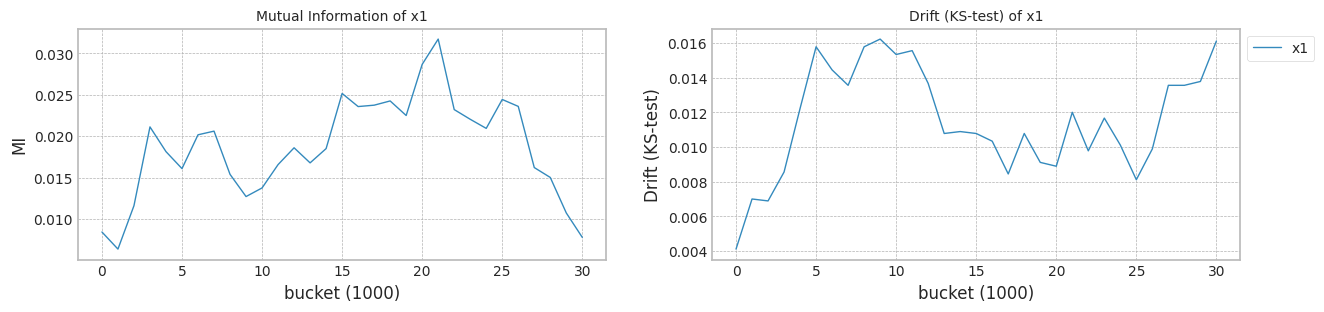

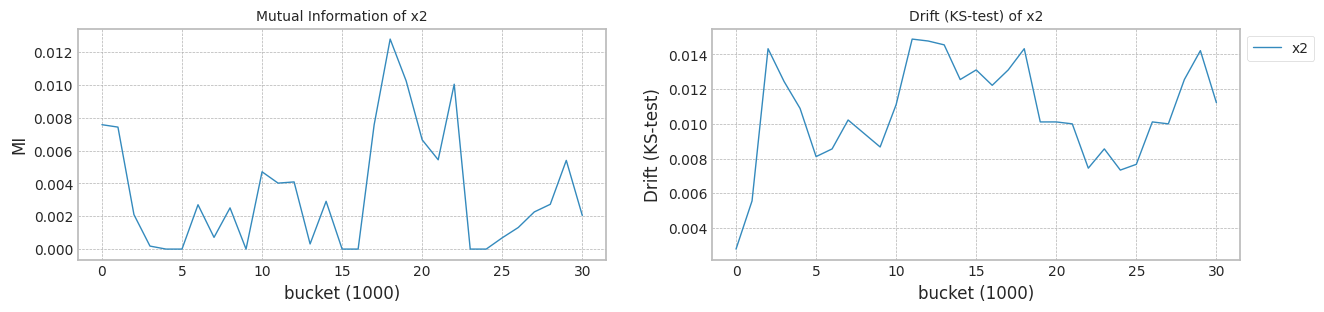

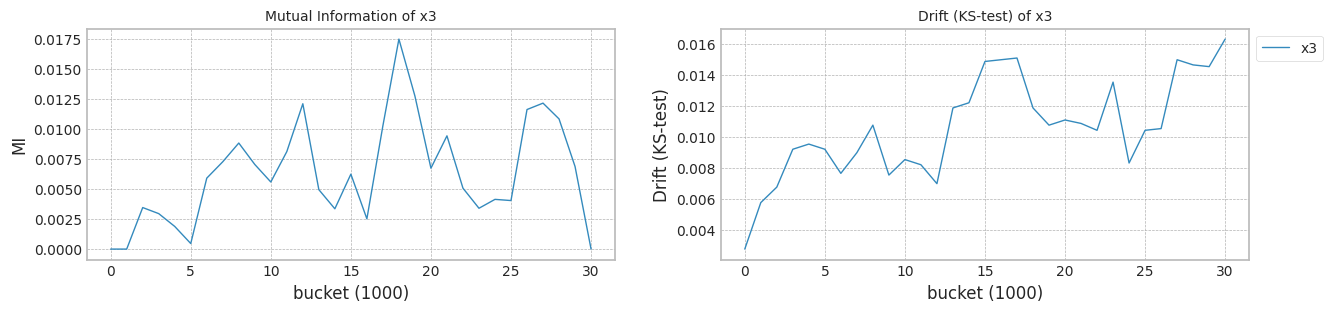

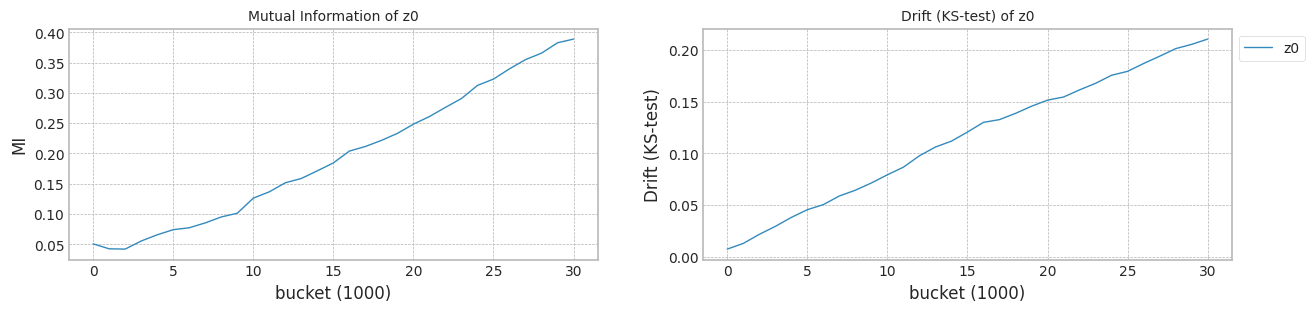

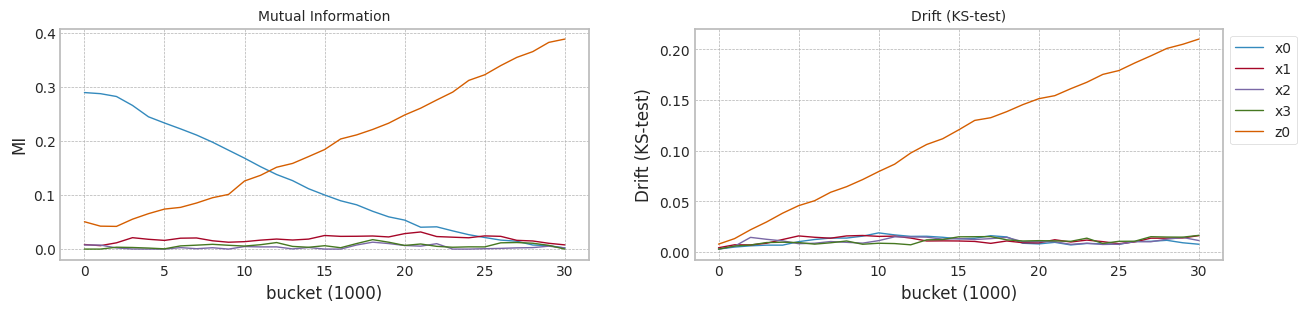

In [162]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)

In [163]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.348766   0
1      0.610533  0.420412  0.508390  0.580336  0.603602   0
2      0.556874  0.464734  0.669603  0.724770  0.452177   0
3      0.344341  0.646524  0.340976  0.528780  0.559737   0
4      0.503142  0.550860  0.598773  0.465698  0.452611   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.612303  39
39996  0.358451  0.483875  0.341855  0.574439  0.395651  39
39997  0.559469  0.343824  0.542547  0.575250  0.268402  39
39998  0.433692  0.530132  0.301231  0.282353  0.347175  39
39999  0.538629  0.637825  0.358726  0.768301  0.890274  39

[40000 rows x 6 columns]

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:22<00:00, 178.23it/s]


Test f1 score: 0.9058766391452161
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.31it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8344416308772443
######################### Trial 0 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:36<00:00, 41.64it/s]


Test f1 score: 0.8950307619498344
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.20it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8399927442379103
Normal model mean        : 0.8344416308772443
Drift tolerant model mean: 0.8399927442379103
######################### Trial 1 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:22<00:00, 178.59it/s]


Test f1 score: 0.9043122748953567
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.33it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8375065994263554
######################### Trial 1 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:35<00:00, 42.09it/s]


Test f1 score: 0.9053698469934705
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.839375689932283
Normal model mean        : 0.8359741151517999
Drift tolerant model mean: 0.8396842170850967
######################### Trial 2 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:19<00:00, 202.52it/s]


Test f1 score: 0.9033064206074587
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.33it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8396546779413054
######################### Trial 2 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:33<00:00, 42.62it/s]


Test f1 score: 0.8614346358985523
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.39it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.827356111552251
Normal model mean        : 0.8372009694149684
Drift tolerant model mean: 0.8355748485741481
######################### Trial 3 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:20<00:00, 190.73it/s]


Test f1 score: 0.8861135890573892
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.44it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8315408258956548
######################### Trial 3 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:32<00:00, 43.32it/s]


Test f1 score: 0.9068975581282227
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.39it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8449501381336887
Normal model mean        : 0.83578593353514
Drift tolerant model mean: 0.8379186709640333
######################### Trial 4 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:20<00:00, 192.06it/s]


Test f1 score: 0.9008888464111632
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8335055466055623
######################### Trial 4 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:34<00:00, 42.52it/s]


Test f1 score: 0.90148966842864
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.46it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.850478556040134
Normal model mean        : 0.8353298561492245
Drift tolerant model mean: 0.8404306479792535
######################### Trial 5 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:20<00:00, 194.01it/s]


Test f1 score: 0.8993843786071566
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.16it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8475028729109889
######################### Trial 5 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:23<00:00, 47.98it/s]


Test f1 score: 0.9086982132338504
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.41it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8455267883389357
Normal model mean        : 0.8373586922761853
Drift tolerant model mean: 0.8412800047058672
######################### Trial 6 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:18<00:00, 215.20it/s]


Test f1 score: 0.8469823901521628
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.37it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8139211717020972
######################### Trial 6 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:12<00:00, 55.21it/s]


Test f1 score: 0.9052469729002498
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.44it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8376750465779211
Normal model mean        : 0.8340104750513156
Drift tolerant model mean: 0.8407650106875891
######################### Trial 7 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:19<00:00, 208.52it/s]


Test f1 score: 0.8356658007206904
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.36it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.7943511959788273
######################### Trial 7 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:07<00:00, 58.88it/s]


Test f1 score: 0.8830152671755725
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.40it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8141321084705669
Normal model mean        : 0.8290530651672545
Drift tolerant model mean: 0.8374358979104614
######################### Trial 8 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:17<00:00, 222.70it/s]


Test f1 score: 0.9065777864915204
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8404362922266949
######################### Trial 8 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:01<00:00, 64.54it/s]


Test f1 score: 0.9043697316151537
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8454192142046115
Normal model mean        : 0.830317868173859
Drift tolerant model mean: 0.8383229330542559
######################### Trial 9 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 238.21it/s]


Test f1 score: 0.9032258064516128
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.46it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8382390629400495
######################### Trial 9 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:58<00:00, 68.54it/s]


Test f1 score: 0.8986512524084779
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8288275389679909
Normal model mean        : 0.831109987650478
Drift tolerant model mean: 0.8373733936456293
######################### Trial 10 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 244.51it/s]


Test f1 score: 0.8979901403109595
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.46it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8435028986813673
######################### Trial 10 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:54<00:00, 73.15it/s]


Test f1 score: 0.8993531202435311
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8499855298474485
Normal model mean        : 0.8322366159260134
Drift tolerant model mean: 0.8385199514821583
######################### Trial 11 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 258.68it/s]


Test f1 score: 0.9051108968177435
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.44it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8404763247869219
######################### Trial 11 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:51<00:00, 77.22it/s]


Test f1 score: 0.8926199962056536
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.26it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8425088859495843
Normal model mean        : 0.832923258331089
Drift tolerant model mean: 0.8388523626877772
######################### Trial 12 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 255.68it/s]


Test f1 score: 0.908456843940715
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.43it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8419915860617551
######################### Trial 12 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:50<00:00, 79.16it/s]


Test f1 score: 0.8926014319809069
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.59it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8409661670548415
Normal model mean        : 0.8336208220026788
Drift tolerant model mean: 0.8390149630237052
######################### Trial 13 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 273.64it/s]


Test f1 score: 0.9031818624112095
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.836647255723935
######################### Trial 13 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:51<00:00, 77.54it/s]


Test f1 score: 0.9086304305474382
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8466583559272227
Normal model mean        : 0.8338369958399114
Drift tolerant model mean: 0.8395609196596707
######################### Trial 14 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 273.46it/s]


Test f1 score: 0.9086811679404272
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.56it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8452449991870155
######################### Trial 14 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:47<00:00, 84.15it/s]


Test f1 score: 0.8908971100442435
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8367252535093
Normal model mean        : 0.834597529396385
Drift tolerant model mean: 0.8393718752496461
######################### Trial 15 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 284.63it/s]


Test f1 score: 0.8959344949062172
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.50it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.846936601457503
######################### Trial 15 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:48<00:00, 82.63it/s]


Test f1 score: 0.9023797960174842
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8334846719248398
Normal model mean        : 0.8353687214002048
Drift tolerant model mean: 0.8390039250418457
######################### Trial 16 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 281.77it/s]


Test f1 score: 0.8876507124588966
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.49it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8188452771732223
######################### Trial 16 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:46<00:00, 85.38it/s]


Test f1 score: 0.89984532095901
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.835755484131141
Normal model mean        : 0.8343967540927353
Drift tolerant model mean: 0.8388128402823926
######################### Trial 17 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 289.16it/s]


Test f1 score: 0.8755448803487235
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8176176001903855
######################### Trial 17 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:46<00:00, 86.54it/s]


Test f1 score: 0.9082703816344552
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.47it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8527974627995776
Normal model mean        : 0.8334645788759381
Drift tolerant model mean: 0.8395897637555695
######################### Trial 18 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 278.91it/s]


Test f1 score: 0.9071123202487368
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8460035698621933
######################### Trial 18 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:45<00:00, 88.73it/s]


Test f1 score: 0.9034875857405082
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8505126818948279
Normal model mean        : 0.8341245257699514
Drift tolerant model mean: 0.8401646541839515
######################### Trial 19 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 296.93it/s]


Test f1 score: 0.9087890625
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8457807051025654
######################### Trial 19 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:45<00:00, 87.73it/s]


Test f1 score: 0.908449323662027
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.114068
dtype: float64
Mean F1 for all data: 0.8517731683022218
Normal model mean        : 0.8347073347365821
Drift tolerant model mean: 0.8407450798898651


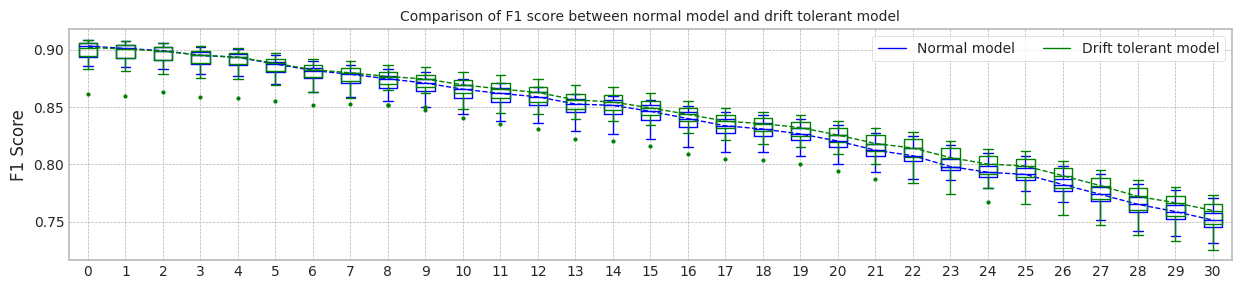

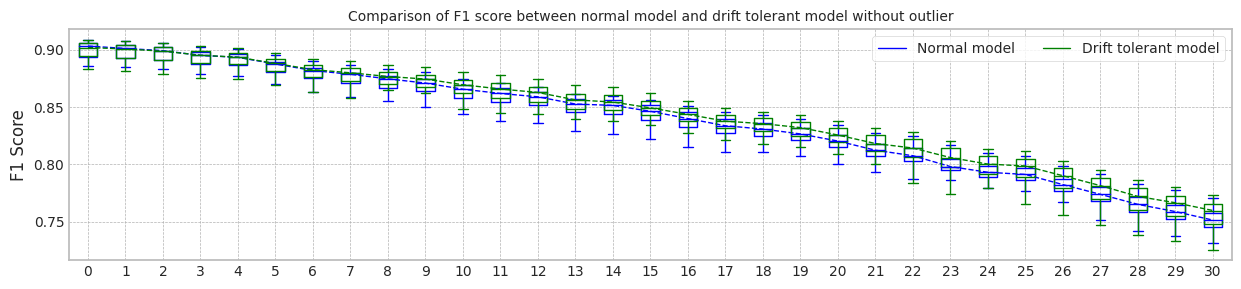

max_mean_trial= 17


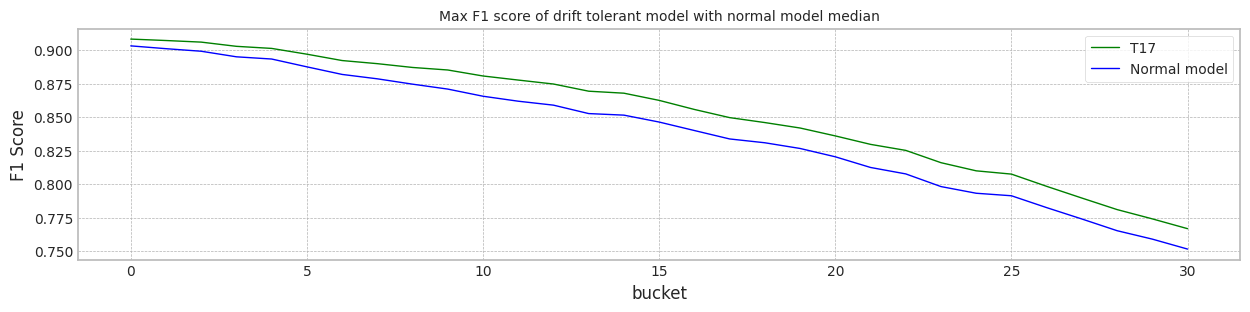

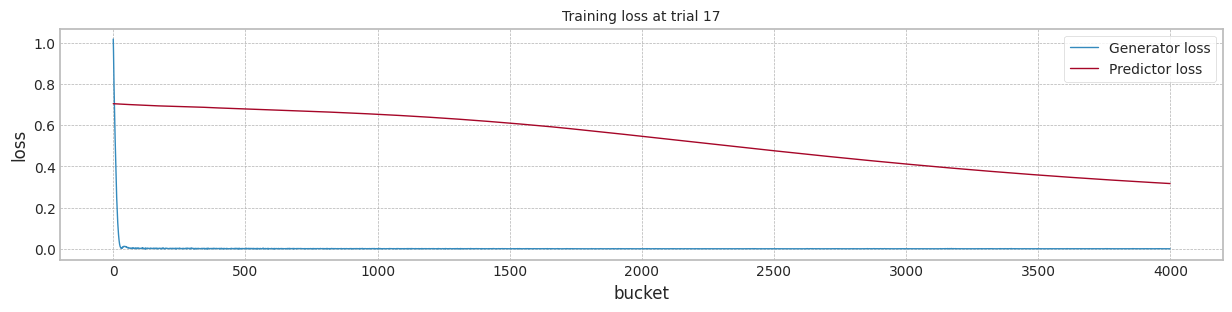

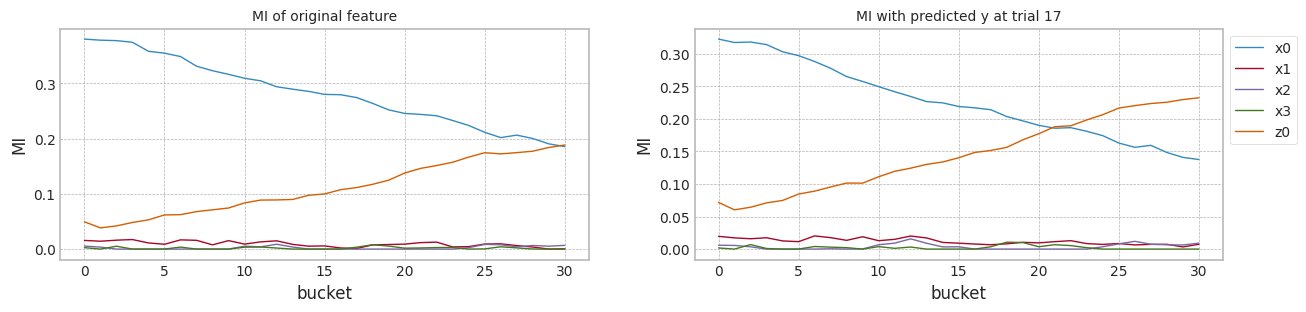

Trial   test_f1   init_f1   mean_f1   last_f1
0    0.0  0.905877  0.905877  0.834442  0.739193
1    1.0  0.904312  0.904312  0.837507  0.745557
2    2.0  0.903306  0.903306  0.839655  0.752625
3    3.0  0.886114  0.886114  0.831541  0.755130
4    4.0  0.900889  0.900889  0.833506  0.745055
5    5.0  0.899384  0.899384  0.847503  0.770400
6    6.0  0.846982  0.846982  0.813921  0.766913
7    7.0  0.835666  0.835666  0.794351  0.739198
8    8.0  0.906578  0.906578  0.840436  0.746335
9    9.0  0.903226  0.903226  0.838239  0.747933
10  10.0  0.897990  0.897990  0.843503  0.763541
11  11.0  0.905111  0.905111  0.840476  0.752464
12  12.0  0.908457  0.908457  0.841992  0.750467
13  13.0  0.903182  0.903182  0.836647  0.746111
14  14.0  0.908681  0.908681  0.845245  0.753359
15  15.0  0.895934  0.895934  0.846937  0.771182
16  16.0  0.887651  0.887651  0.818845  0.731250
17  17.0  0.875545  0.875545  0.817618  0.740012
18  18.0  0.907112  0.907112  0.846004  0.760327
19  19.0  0.908789  0.908789  0.845781  0.757224
20  mean  0.894539  0.894539  0.834707  0.751714
21   sem  0.004515  0.004515  0.003050  0.002432

Trial   test_f1   init_f1   mean_f1   last_f1
0    0.0  0.895031  0.895031  0.839993  0.761584
1    1.0  0.905370  0.905370  0.839376  0.747432
2    2.0  0.861435  0.861435  0.827356  0.764097
3    3.0  0.906898  0.906898  0.844950  0.757408
4    4.0  0.901490  0.901490  0.850479  0.773568
5    5.0  0.908698  0.908698  0.845527  0.753836
6    6.0  0.905247  0.905247  0.837675  0.747955
7    7.0  0.883015  0.883015  0.814132  0.725737
8    8.0  0.904370  0.904370  0.845419  0.762188
9    9.0  0.898651  0.898651  0.828828  0.735808
10  10.0  0.899353  0.899353  0.849986  0.773756
11  11.0  0.892620  0.892620  0.842509  0.769717
12  12.0  0.892601  0.892601  0.840966  0.756921
13  13.0  0.908630  0.908630  0.846658  0.759063
14  14.0  0.890897  0.890897  0.836725  0.760618
15  15.0  0.902380  0.902380  0.833485  0.740007
16  16.0  0.899845  0.899845  0.835755  0.747501
17  17.0  0.908270  0.908270  0.852797  0.766700
18  18.0  0.903488  0.903488  0.850513  0.771135
19  19.0  0.908449  0.908449  0.851773  0.765196
20  mean  0.898837  0.898837  0.840745  0.757011
21   sem  0.002514  0.002514  0.002163  0.002894

In [164]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [165]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


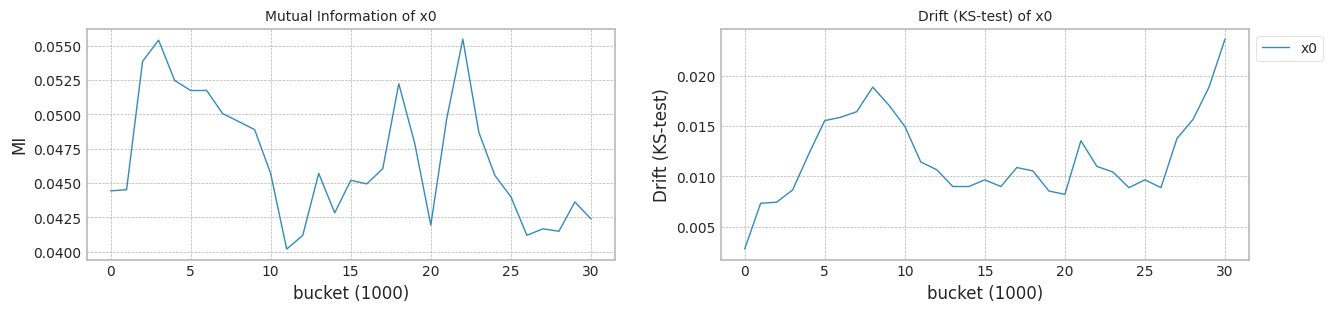

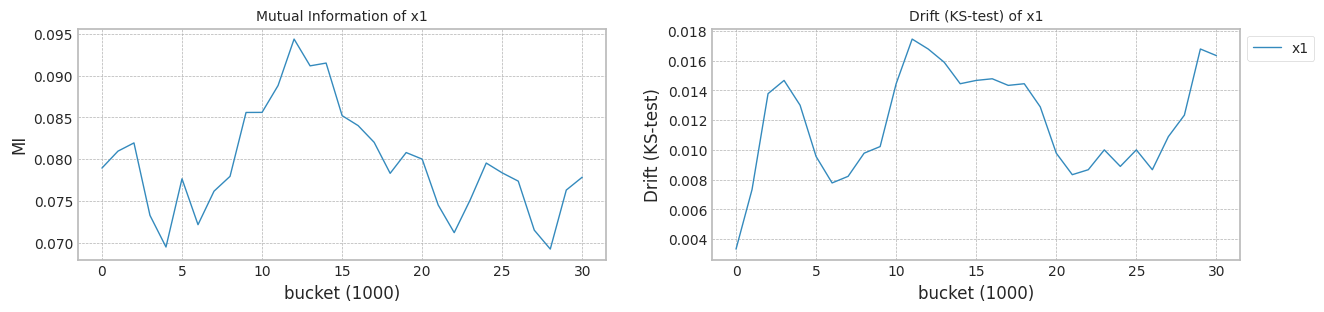

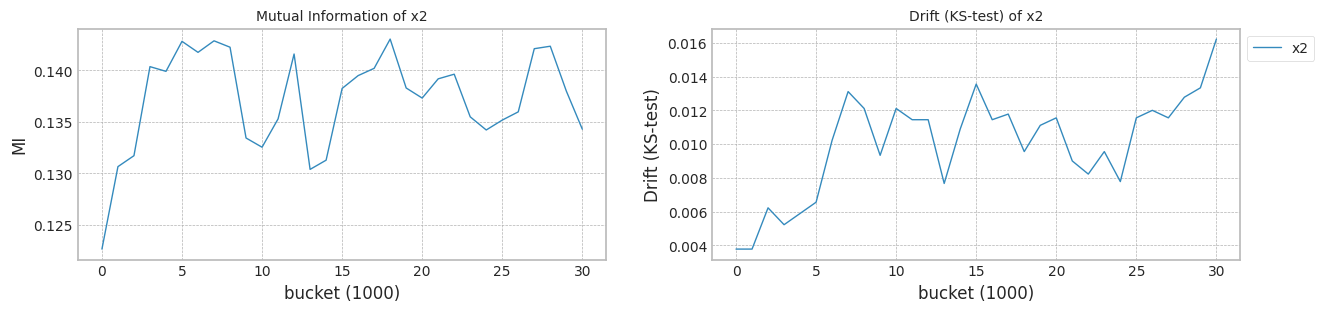

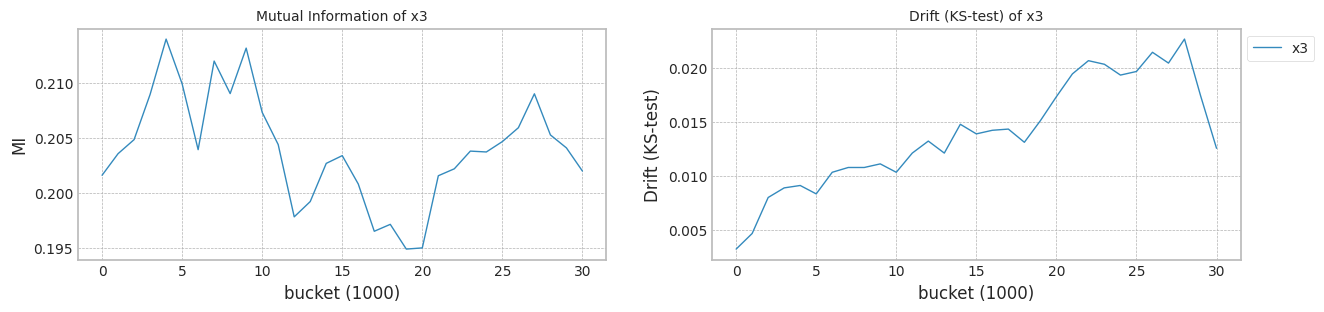

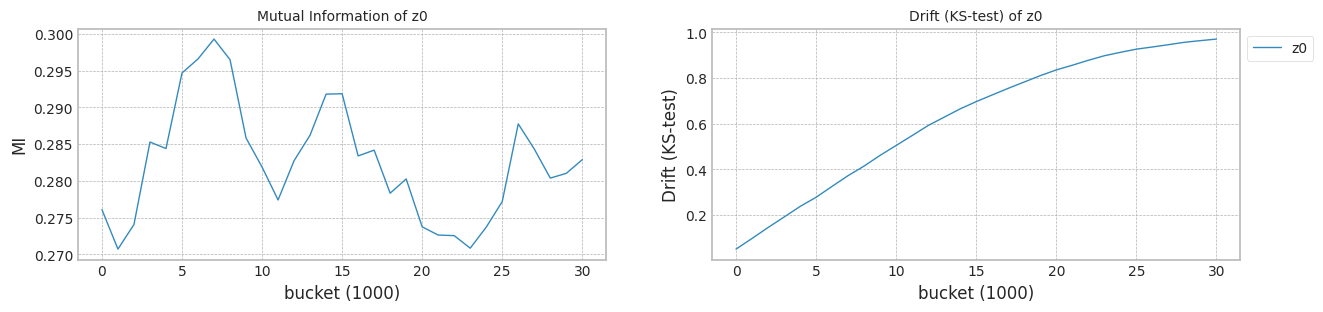

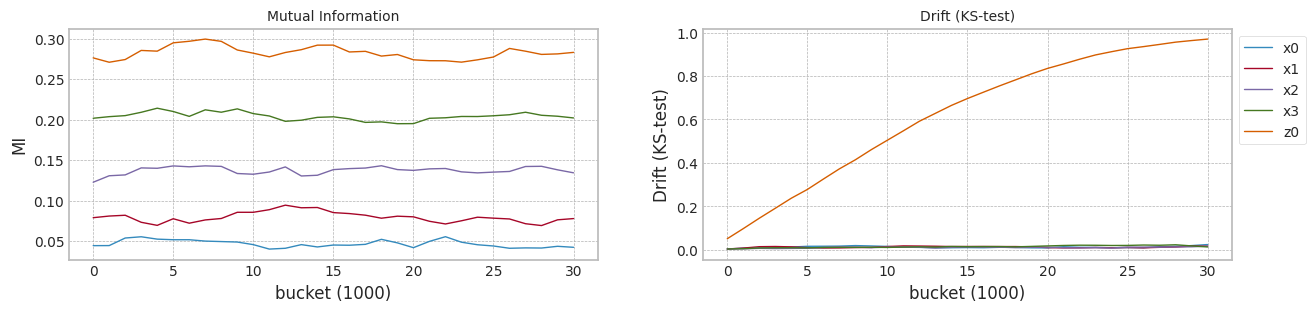

In [166]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [167]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.477486   0
1      0.447230  0.556479  0.629077  0.735705  0.578715   0
2      0.489501  0.704159  0.760582  0.582973  0.354045   0
3      0.581446  0.301839  0.443337  0.515173  0.360338   0
4      0.571642  0.639275  0.524701  0.583380  0.597569   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.989291  39
39996  0.426322  0.302644  0.484909  0.587518  1.004704  39
39997  0.374186  0.587769  0.624447  0.598315  1.321791  39
39998  0.470439  0.265430  0.218971  0.645349  1.148847  39
39999  0.654583  0.419378  0.800216  0.614031  1.319193  39

[40000 rows x 6 columns]

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:24<00:00, 163.85it/s]


Test f1 score: 0.9102426454799226
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.32it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.760588938342107
######################### Trial 0 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:38<00:00, 40.60it/s]


Test f1 score: 0.9014648540415218
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.25it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7562760051861801
Normal model mean        : 0.760588938342107
Drift tolerant model mean: 0.7562760051861801
######################### Trial 1 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:22<00:00, 177.99it/s]


Test f1 score: 0.9103581385374224
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.43it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7572086441394313
######################### Trial 1 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:33<00:00, 42.64it/s]


Test f1 score: 0.9091689929138931
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.21it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7688393497428776
Normal model mean        : 0.7588987912407692
Drift tolerant model mean: 0.7625576774645288
######################### Trial 2 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:19<00:00, 202.55it/s]


Test f1 score: 0.9110274341043573
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.51it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7625579278481999
######################### Trial 2 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:26<00:00, 46.48it/s]


Test f1 score: 0.8606965174129353
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.56it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7752289560689644
Normal model mean        : 0.760118503443246
Drift tolerant model mean: 0.7667814369993406
######################### Trial 3 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:18<00:00, 214.93it/s]


Test f1 score: 0.8798701298701298
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7722115871384793
######################### Trial 3 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:24<00:00, 47.15it/s]


Test f1 score: 0.9068191444303262
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.49it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7568775325532305
Normal model mean        : 0.7631417743670543
Drift tolerant model mean: 0.7643054608878131
######################### Trial 4 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:18<00:00, 213.22it/s]


Test f1 score: 0.9081415174765558
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.47it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7550275479228811
######################### Trial 4 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:10<00:00, 56.86it/s]


Test f1 score: 0.9074113399872584
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.37it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7582320995721015
Normal model mean        : 0.7615189290782196
Drift tolerant model mean: 0.7630907886246708
######################### Trial 5 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:18<00:00, 221.22it/s]


Test f1 score: 0.8963226028181922
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.48it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7762407626983073
######################### Trial 5 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:07<00:00, 59.25it/s]


Test f1 score: 0.9113597246127367
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7628191516174528
Normal model mean        : 0.7639725680149009
Drift tolerant model mean: 0.7630455157901346
######################### Trial 6 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:17<00:00, 226.80it/s]


Test f1 score: 0.8701527614571092
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7224152380466197
######################### Trial 6 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:02<00:00, 63.72it/s]


Test f1 score: 0.8981186388403414
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7434986319591746
Normal model mean        : 0.7580358065908607
Drift tolerant model mean: 0.7602531038142831
######################### Trial 7 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 239.12it/s]


Test f1 score: 0.8409197559831064
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7087912584351215
######################### Trial 7 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [01:01<00:00, 64.75it/s]


Test f1 score: 0.8634902075416544
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.59it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7283856679546509
Normal model mean        : 0.7518802380713934
Drift tolerant model mean: 0.7562696743318291
######################### Trial 8 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 245.45it/s]


Test f1 score: 0.9096795079313693
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.47it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7650321667556682
######################### Trial 8 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:56<00:00, 70.66it/s]


Test f1 score: 0.9080509389164688
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.47it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7711701748287175
Normal model mean        : 0.7533415634807573
Drift tolerant model mean: 0.7579252854981501
######################### Trial 9 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 252.24it/s]


Test f1 score: 0.9066068950795176
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.756924868811586
######################### Trial 9 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:54<00:00, 73.69it/s]


Test f1 score: 0.9098081023454158
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7587469602751109
Normal model mean        : 0.7536998940138402
Drift tolerant model mean: 0.758007452975846
######################### Trial 10 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 266.13it/s]


Test f1 score: 0.9090127833279621
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7642766978804223
######################### Trial 10 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:51<00:00, 77.68it/s]


Test f1 score: 0.9091102823654768
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7545562911692293
Normal model mean        : 0.7546614216380749
Drift tolerant model mean: 0.7576937109934264
######################### Trial 11 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 270.59it/s]


Test f1 score: 0.8865106433023638
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7874889222472026
######################### Trial 11 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:49<00:00, 80.54it/s]


Test f1 score: 0.9058133333333332
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7532377434830988
Normal model mean        : 0.7573970466888356
Drift tolerant model mean: 0.7573223803675658
######################### Trial 12 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 276.67it/s]


Test f1 score: 0.9083555082490686
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7550832857647626
######################### Trial 12 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:47<00:00, 83.71it/s]


Test f1 score: 0.8863922962283618
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7678951215899841
Normal model mean        : 0.7572190650792915
Drift tolerant model mean: 0.7581356681539057
######################### Trial 13 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 280.99it/s]


Test f1 score: 0.8940113517896444
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7829315973651566
######################### Trial 13 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:46<00:00, 85.85it/s]


Test f1 score: 0.9099322070375552
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7663183940003048
Normal model mean        : 0.7590556745282818
Drift tolerant model mean: 0.7587201485715056
######################### Trial 14 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 292.16it/s]


Test f1 score: 0.9110205831903945
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.63it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7586937136614099
######################### Trial 14 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:45<00:00, 88.51it/s]


Test f1 score: 0.8991342442891416
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7420263123994617
Normal model mean        : 0.7590315438038236
Drift tolerant model mean: 0.7576072261600361
######################### Trial 15 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 291.36it/s]


Test f1 score: 0.908315565031983
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7574071261816501
######################### Trial 15 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:44<00:00, 90.12it/s]


Test f1 score: 0.9094813701277784
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.67it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.760032393818291
Normal model mean        : 0.7589300177024378
Drift tolerant model mean: 0.7577587991386769
######################### Trial 16 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 299.49it/s]


Test f1 score: 0.8972384765424495
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.65it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7441869977853438
######################### Trial 16 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:43<00:00, 91.10it/s]


Test f1 score: 0.9088385994876175
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7573441694935309
Normal model mean        : 0.7580627812367264
Drift tolerant model mean: 0.7577344091595507
######################### Trial 17 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 297.16it/s]


Test f1 score: 0.889495500960469
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.65it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7391462974711668
######################### Trial 17 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:43<00:00, 92.19it/s]


Test f1 score: 0.909815752612865
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.63it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7639278674850859
Normal model mean        : 0.7570118654719731
Drift tolerant model mean: 0.758078490177636
######################### Trial 18 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 302.60it/s]


Test f1 score: 0.9107257546563905
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.59it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7582834772132935
######################### Trial 18 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:42<00:00, 93.07it/s]


Test f1 score: 0.9098896389156755
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.65it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.763343455546367
Normal model mean        : 0.7570787924057268
Drift tolerant model mean: 0.7583555936180955
######################### Trial 19 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:13<00:00, 304.85it/s]


Test f1 score: 0.9092872570194385
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7729574817689528
######################### Trial 19 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:42<00:00, 94.11it/s]


Test f1 score: 0.9104349689307908
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.65it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.7602071494551386
Normal model mean        : 0.7578727268738882
Drift tolerant model mean: 0.7584481714099477


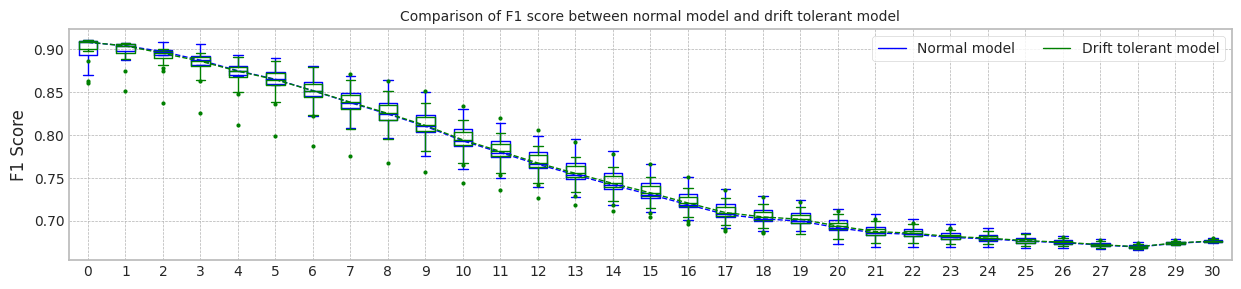

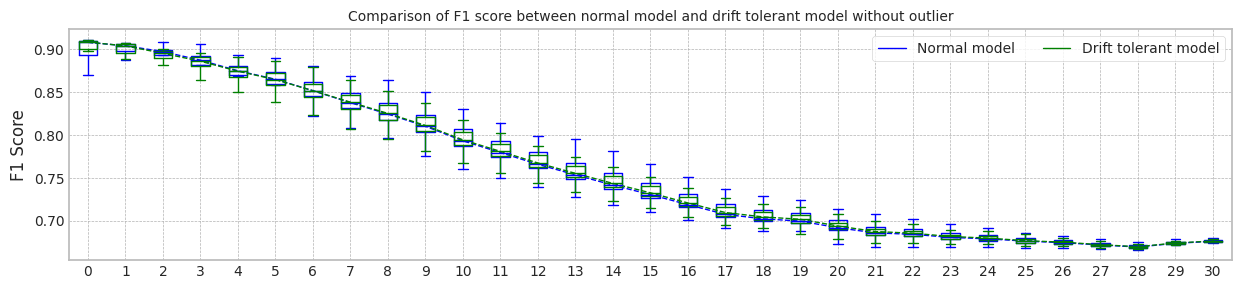

max_mean_trial= 2


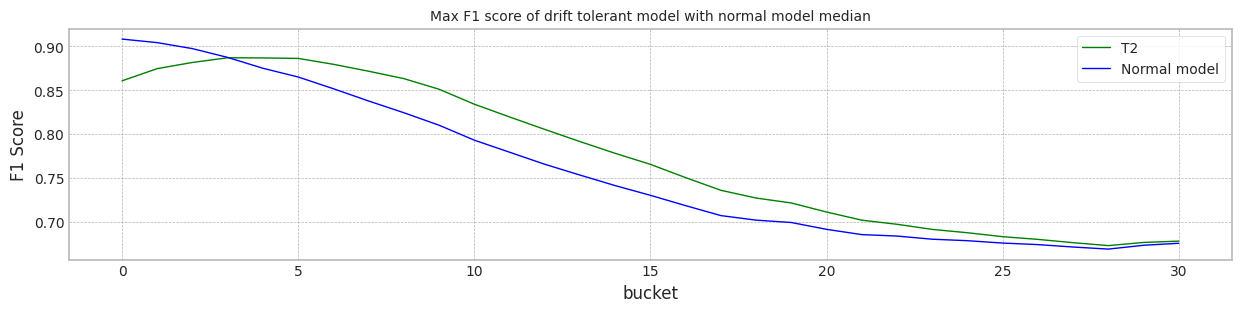

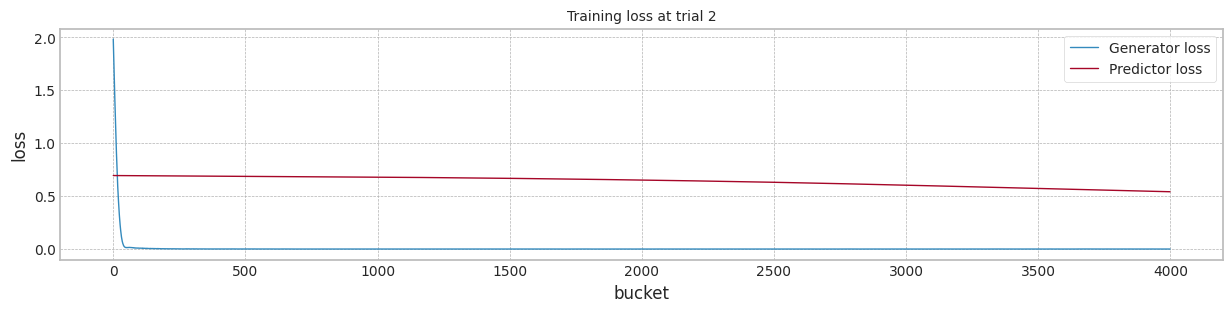

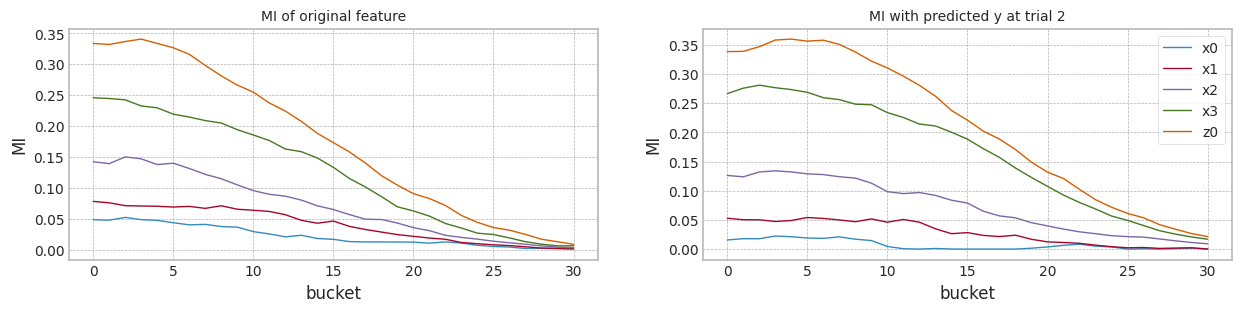

Trial   test_f1   init_f1   mean_f1   last_f1
0    0.0  0.910243  0.910243  0.760589  0.675771
1    1.0  0.910358  0.910358  0.757209  0.675323
2    2.0  0.911027  0.911027  0.762558  0.677372
3    3.0  0.879870  0.879870  0.772212  0.677221
4    4.0  0.908142  0.908142  0.755028  0.675572
5    5.0  0.896323  0.896323  0.776241  0.676371
6    6.0  0.870153  0.870153  0.722415  0.674427
7    7.0  0.840920  0.840920  0.708791  0.674328
8    8.0  0.909680  0.909680  0.765032  0.677221
9    9.0  0.906607  0.906607  0.756925  0.676321
10  10.0  0.909013  0.909013  0.764277  0.676871
11  11.0  0.886511  0.886511  0.787489  0.678879
12  12.0  0.908356  0.908356  0.755083  0.675323
13  13.0  0.894011  0.894011  0.782932  0.678627
14  14.0  0.911021  0.911021  0.758694  0.675472
15  15.0  0.908316  0.908316  0.757407  0.675971
16  16.0  0.897238  0.897238  0.744187  0.675173
17  17.0  0.889496  0.889496  0.739146  0.675074
18  18.0  0.910726  0.910726  0.758283  0.675622
19  19.0  0.909287  0.909287  0.772957  0.679685
20  mean  0.898365  0.898365  0.757873  0.676331
21   sem  0.004027  0.004027  0.004174  0.000328

Trial   test_f1   init_f1   mean_f1   last_f1
0    0.0  0.901465  0.901465  0.756276  0.676171
1    1.0  0.909169  0.909169  0.768839  0.677923
2    2.0  0.860697  0.860697  0.775229  0.678325
3    3.0  0.906819  0.906819  0.756878  0.676271
4    4.0  0.907411  0.907411  0.758232  0.676271
5    5.0  0.911360  0.911360  0.762819  0.676221
6    6.0  0.898119  0.898119  0.743499  0.674974
7    7.0  0.863490  0.863490  0.728386  0.675323
8    8.0  0.908051  0.908051  0.771170  0.679282
9    9.0  0.909808  0.909808  0.758747  0.675572
10  10.0  0.909110  0.909110  0.754556  0.675273
11  11.0  0.905813  0.905813  0.753238  0.675323
12  12.0  0.886392  0.886392  0.767895  0.675871
13  13.0  0.909932  0.909932  0.766318  0.677321
14  14.0  0.899134  0.899134  0.742026  0.674775
15  15.0  0.909481  0.909481  0.760032  0.676721
16  16.0  0.908839  0.908839  0.757344  0.675422
17  17.0  0.909816  0.909816  0.763928  0.676221
18  18.0  0.909890  0.909890  0.763343  0.676971
19  19.0  0.910435  0.910435  0.760207  0.675871
20  mean  0.901762  0.901762  0.758448  0.676305
21   sem  0.003312  0.003312  0.002422  0.000262

In [168]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

### Dataset 준비

In [71]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

In [72]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

MI Analysis MI Max 0.14553, Min 0.02498, Mean 0.08409, Std 0.04454
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:06<00:00,  4.72it/s]


KeyboardInterrupt: ignored

In [ ]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]


In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b'])+1)

## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [ ]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


##### Data 정제

In [ ]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [ ]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

##### Dataset 만들기

In [ ]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [ ]:

X[2010].shape

(11497, 81)

In [ ]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [ ]:
seed_everything(12)

X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries                  0.375327
last_fico_range_high        0.090427
last_pymnt_amnt             0.085496
total_rec_late_fee          0.038954
int_rate                    0.016850
                              ...   
F2                          0.000000
chargeoff_within_12_mths    0.000000
G1                          0.000000
G3                          0.000000
D3                          0.000000
Name: MI Scores, Length: 81, dtype: float64


In [ ]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [ ]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term',
 'fico_range_high',
 'DirectPay',
 'inq_last_6mths',
 'A2']

In [ ]:
top_columns = [
    'last_fico_range_high',
    'last_pymnt_amnt',
    'total_rec_late_fee',
    #'int_rate',
    'term']

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 1]

In [ ]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]
#X2_df_t5 = X2_df[top_columns]

#### 실험

In [ ]:
train_size = 100000
test_size = 20000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

MI Analysis MI Max 0.31573, Min 0.00029, Mean 0.10755, Std 0.12210
Dataset structure X_train, (100000, 7) X_test, (100000, 7) X_live (1259680, 7)
Truncate 99680 rows from live_set (1259680, 7)
Search MI & Drift...for X_live_set (58, 100000, 7)


  7%|▋         | 4/58 [00:14<03:19,  3.70s/it]

In [ ]:
bucket_size = 3000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  term    b
0                    0.922353         0.023107            0.000000   0.0    0
1                    0.857647         0.007334            0.000000   0.0    0
2                    0.722353         0.267822            0.000000   0.0    0
3                    0.863529         0.015264            0.000000   0.0    0
4                    0.945882         0.019326            0.000000   0.0    0
...                       ...              ...                 ...   ...  ...
1279675              0.910588         0.000189            0.052309   0.0  426
1279676              0.851765         0.283658            0.000000   0.0  426
1279677              0.898824         0.235068            0.000000   0.0  426
1279678              0.916471         0.682716            0.000000   0.0  426
1279679              0.875294         0.264953            0.000000   1.0  426

[1279680 rows x 5 columns]

lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 559.33it/s]


Test f1 score: 0.9169783729235529
X_live.shape (1269680, 5)
Truncate 89680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 5])


100%|██████████| 118/118 [03:48<00:00,  1.94s/it]


mean of drift:
last_fico_range_high    0.070345
last_pymnt_amnt         0.136316
total_rec_late_fee      0.021553
Y                       0.020612
dtype: float64
Mean F1 for all data: 0.8988572765410713
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 553.69it/s]


Test f1 score: 0.9151136719785916
X_live.shape (1269680, 5)
Truncate 89680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 5])


100%|██████████| 118/118 [03:47<00:00,  1.93s/it]


mean of drift:
last_fico_range_high    0.070345
last_pymnt_amnt         0.136316
total_rec_late_fee      0.021553
Y                       0.020612
dtype: float64
Mean F1 for all data: 0.8873854343213327
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 575.90it/s]


Test f1 score: 0.91863961712761
X_live.shape (1269680, 5)
Truncate 89680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 5])


100%|██████████| 118/118 [03:49<00:00,  1.94s/it]


mean of drift:
last_fico_range_high    0.070345
last_pymnt_amnt         0.136316
total_rec_late_fee      0.021553
Y                       0.020612
dtype: float64
Mean F1 for all data: 0.9008530896972321
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:24<00:00, 161.27it/s]


Test f1 score: 0.9286048236782884
X_live.shape (1269680, 5)
Truncate 89680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 5])


100%|██████████| 118/118 [03:42<00:00,  1.88s/it]


mean of drift:
last_fico_range_high    0.185600
last_pymnt_amnt         0.572111
total_rec_late_fee      0.983702
Y                       0.993733
dtype: float64
Mean F1 for all data: 0.8960431587463513
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:24<00:00, 161.90it/s]


Test f1 score: 0.9158910075826582
X_live.shape (1269680, 5)
Truncate 89680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 5])


100%|██████████| 118/118 [03:41<00:00,  1.88s/it]


mean of drift:
last_fico_range_high    0.440672
last_pymnt_amnt         0.576994
total_rec_late_fee      0.948130
Y                       0.993733
dtype: float64
Mean F1 for all data: 0.8961937590652105
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:24<00:00, 162.33it/s]


Test f1 score: 0.9186461598034826
X_live.shape (1269680, 5)
Truncate 89680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 5])


100%|██████████| 118/118 [03:42<00:00,  1.89s/it]


mean of drift:
last_fico_range_high    0.330602
last_pymnt_amnt         0.563122
total_rec_late_fee      0.942480
Y                       0.990920
dtype: float64
Mean F1 for all data: 0.9196501939914551


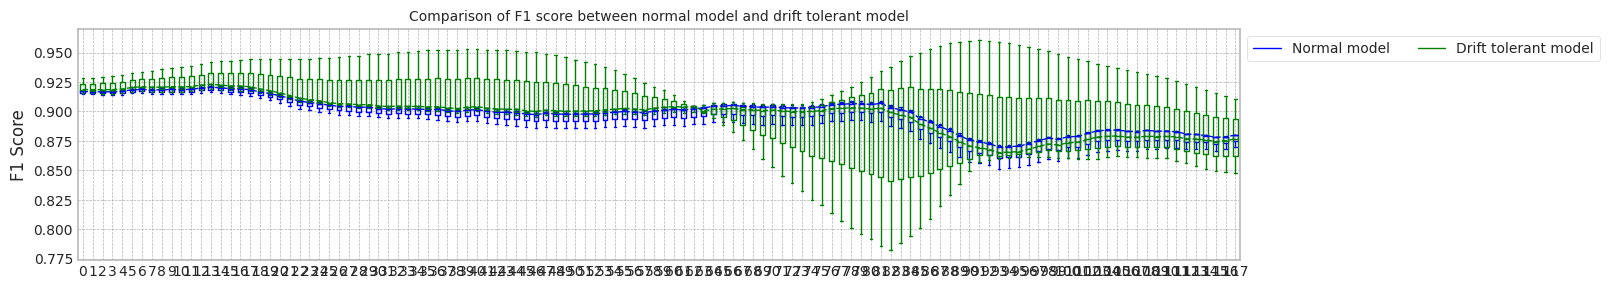

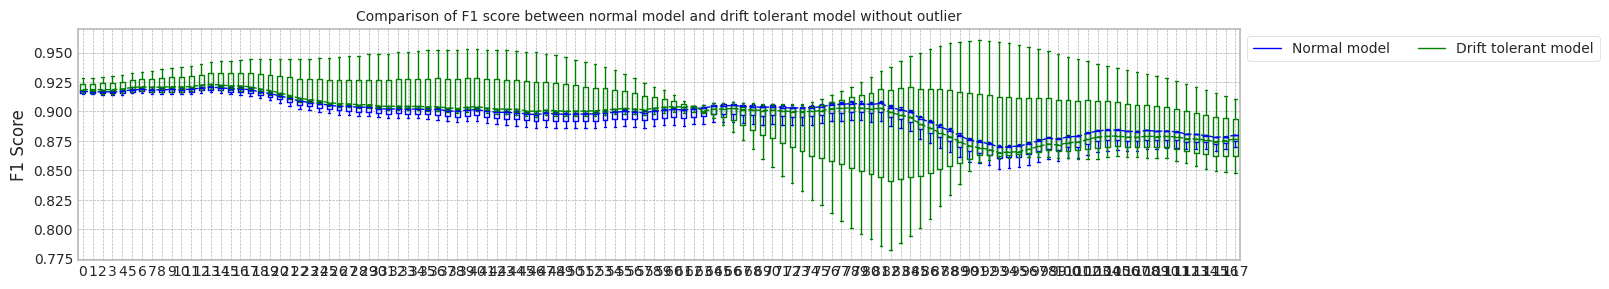

max_mean_trial= 2


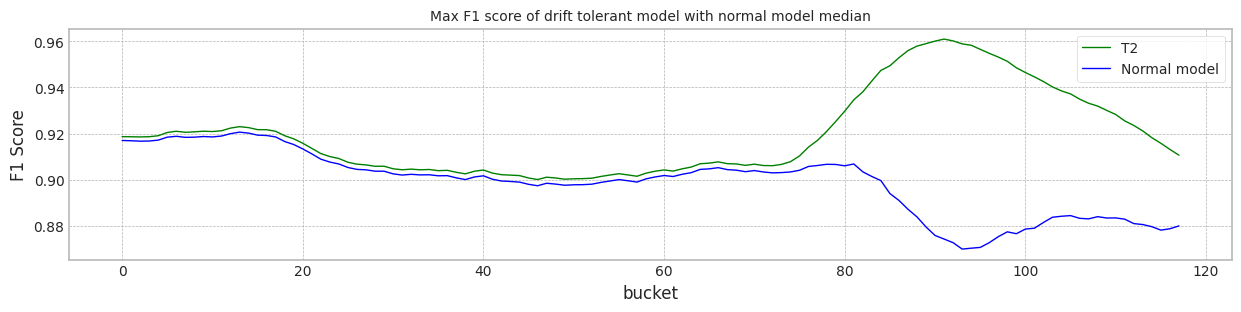

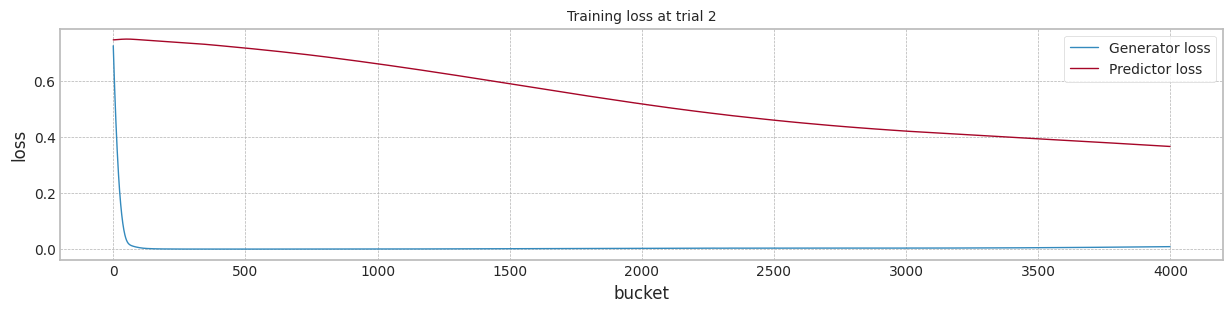

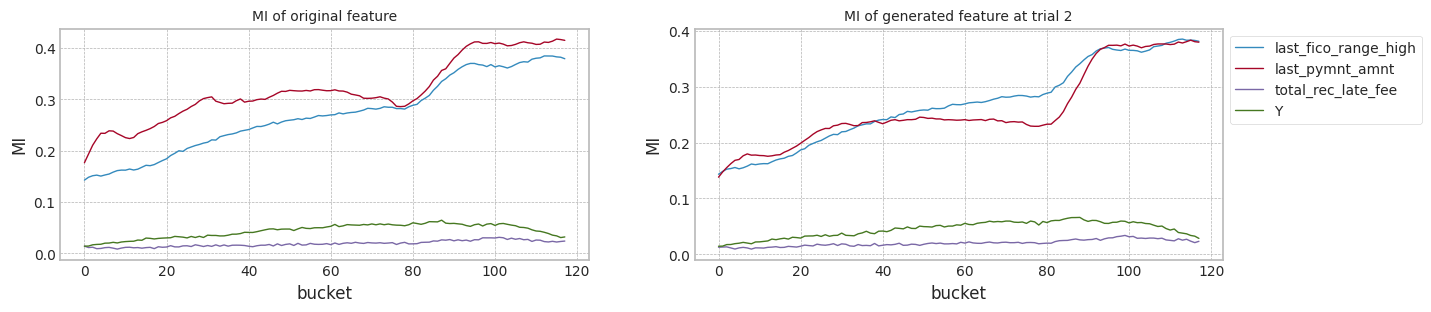

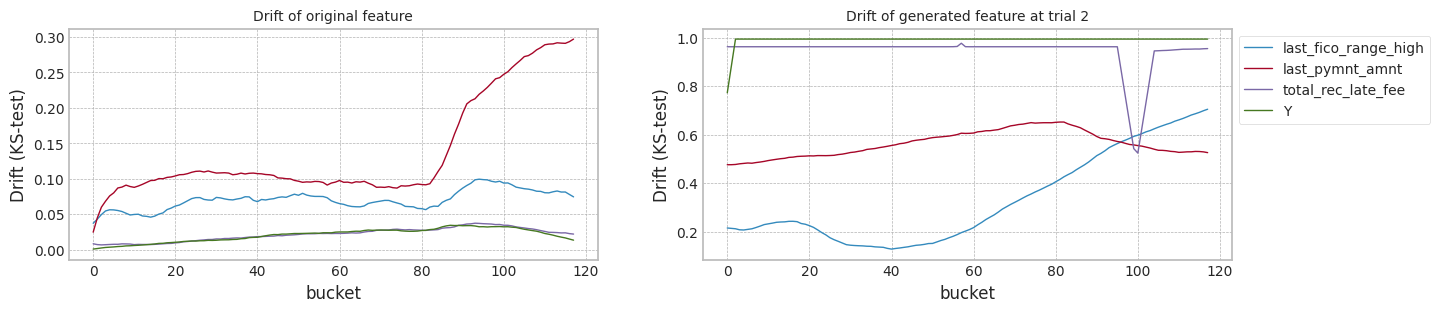

Trial   test_f1   init_f1   mean_f1   last_f1
0   0.0  0.916978  0.916978  0.898857  0.879901
1   1.0  0.915114  0.915114  0.887385  0.870163
2   2.0  0.918640  0.918640  0.900853  0.879978
3  mean  0.916911  0.916911  0.895699  0.876681
4   sem  0.001018  0.001018  0.004196  0.003259

Trial   test_f1   init_f1   mean_f1   last_f1
0   0.0  0.928605  0.928605  0.896043  0.847905
1   1.0  0.915891  0.915891  0.896194  0.876723
2   2.0  0.918646  0.918646  0.919650  0.910595
3  mean  0.921047  0.921047  0.903962  0.878408
4   sem  0.003862  0.003862  0.007844  0.018116

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 130) #np.max(X1['b'])+1)


### #2

In [ ]:
top_columns = list(mi_scores[1:10].index)
top_columns

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

In [ ]:
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]

In [ ]:
train_size = 90000
test_size = 10000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

MI Analysis MI Max 0.31563, Min 0.02171, Mean 0.15192, Std 0.11897
Dataset structure X_train, (90000, 5) X_test, (90000, 5) X_live (1269680, 5)
Truncate 89680 rows from live_set (1269680, 5)
Search MI & Drift...for X_live_set (118, 90000, 5)


  4%|▍         | 5/118 [00:12<04:38,  2.47s/it]


KeyboardInterrupt: ignored

In [ ]:
bucket_size = 10000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 300) #np.max(X1['b'])+1)

### #3

In [ ]:
'''
['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term']
 '''

In [ ]:
top_columns = list(mi_scores[1:6].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term']

In [ ]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1]

In [ ]:
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]

In [ ]:
train_size = 90000
test_size = 10000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

KeyboardInterrupt: ignored

In [ ]:
bucket_size = 10000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  int_rate  \
0                    0.922353         0.023107            0.000000  0.418593   
1                    0.857647         0.007334            0.000000  0.347201   
2                    0.722353         0.267822            0.000000  0.472008   
3                    0.863529         0.015264            0.000000  0.543400   
4                    0.945882         0.019326            0.000000  0.329224   
...                       ...              ...                 ...       ...   
1279675              0.910588         0.000189            0.052309  0.231638   
1279676              0.851765         0.283658            0.000000  0.231638   
1279677              0.898824         0.235068            0.000000  0.130971   
1279678              0.916471         0.682716            0.000000 -0.005136   
1279679              0.875294         0.264953            0.000000  1.303030   

         term    b  
0         0.0    0  
1         0.0    0  
2         0.0    0  
3         0.0    0  
4         0.0    0  
...       ...  ...  
1279675   0.0  127  
1279676   0.0  127  
1279677   0.0  127  
1279678   0.0  127  
1279679   1.0  127  

[1279680 rows x 6 columns]

lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 563.53it/s]


Test f1 score: 0.9154104610410371
X_live.shape (1269680, 6)
Truncate 89680 rows from live_set (1269680, 6)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 6])


100%|██████████| 118/118 [04:45<00:00,  2.42s/it]


mean of drift:
last_fico_range_high    0.070345
last_pymnt_amnt         0.136316
total_rec_late_fee      0.021553
int_rate                0.128013
term                    0.022858
dtype: float64
Mean F1 for all data: 0.8885835191276548
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 539.18it/s]


Test f1 score: 0.9151136719785916
X_live.shape (1269680, 6)
Truncate 89680 rows from live_set (1269680, 6)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 6])


100%|██████████| 118/118 [04:49<00:00,  2.45s/it]


mean of drift:
last_fico_range_high    0.070345
last_pymnt_amnt         0.136316
total_rec_late_fee      0.021553
int_rate                0.128013
term                    0.022858
dtype: float64
Mean F1 for all data: 0.8873854343213327
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 539.75it/s]


Test f1 score: 0.9170385959819538
X_live.shape (1269680, 6)
Truncate 89680 rows from live_set (1269680, 6)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 6])


100%|██████████| 118/118 [04:43<00:00,  2.40s/it]


mean of drift:
last_fico_range_high    0.070345
last_pymnt_amnt         0.136316
total_rec_late_fee      0.021553
int_rate                0.128013
term                    0.022858
dtype: float64
Mean F1 for all data: 0.8936690444544568
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:37<00:00, 107.52it/s]


Test f1 score: 0.9345633984123578
X_live.shape (1269680, 6)
Truncate 89680 rows from live_set (1269680, 6)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 6])


100%|██████████| 118/118 [04:39<00:00,  2.37s/it]


mean of drift:
last_fico_range_high    0.296042
last_pymnt_amnt         0.447626
total_rec_late_fee      0.972604
int_rate                0.205972
term                    0.747615
dtype: float64
Mean F1 for all data: 0.9041555770130897
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:37<00:00, 107.95it/s]


Test f1 score: 0.9151136719785916
X_live.shape (1269680, 6)
Truncate 89680 rows from live_set (1269680, 6)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 6])


100%|██████████| 118/118 [04:38<00:00,  2.36s/it]


mean of drift:
last_fico_range_high    0.101964
last_pymnt_amnt         0.388907
total_rec_late_fee      0.958007
int_rate                0.128368
term                    0.744917
dtype: float64
Mean F1 for all data: 0.8873854343213327
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:37<00:00, 107.52it/s]


Test f1 score: 0.931920463753662
X_live.shape (1269680, 6)
Truncate 89680 rows from live_set (1269680, 6)
Search MI & Drift...for X_live_set torch.Size([118, 90000, 6])


100%|██████████| 118/118 [04:52<00:00,  2.48s/it]


mean of drift:
last_fico_range_high    0.484831
last_pymnt_amnt         0.538115
total_rec_late_fee      0.969837
int_rate                0.131548
term                    0.763944
dtype: float64
Mean F1 for all data: 0.958856247756004


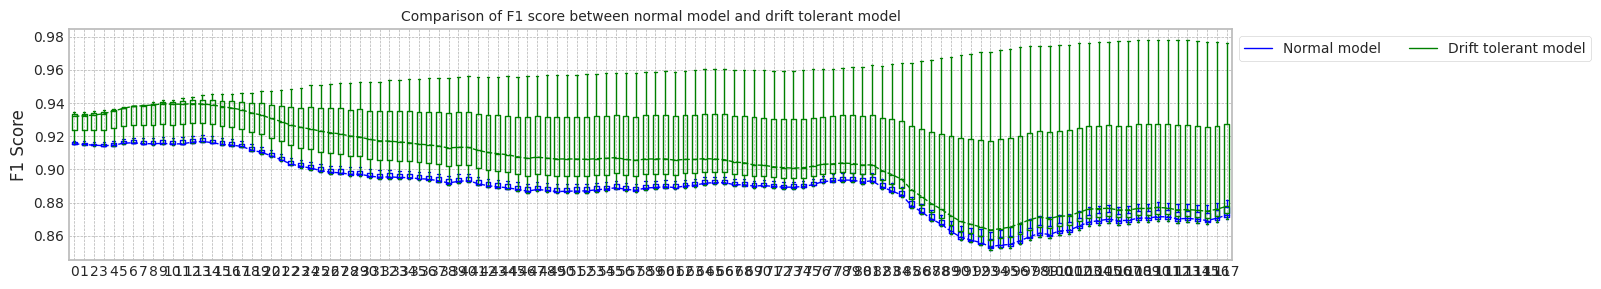

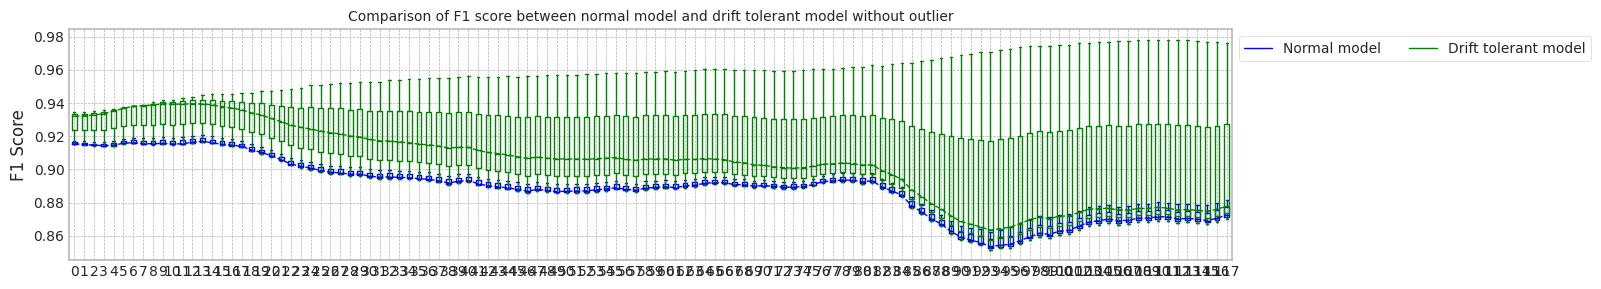

max_mean_trial= 2


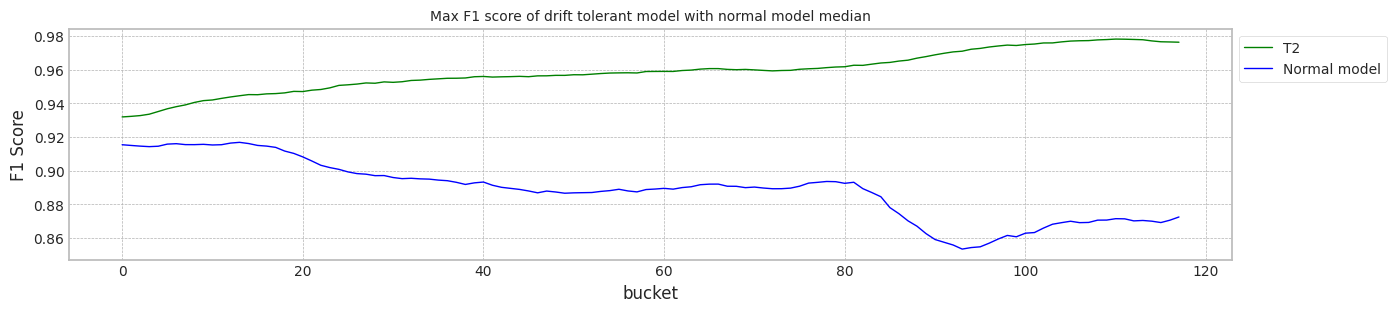

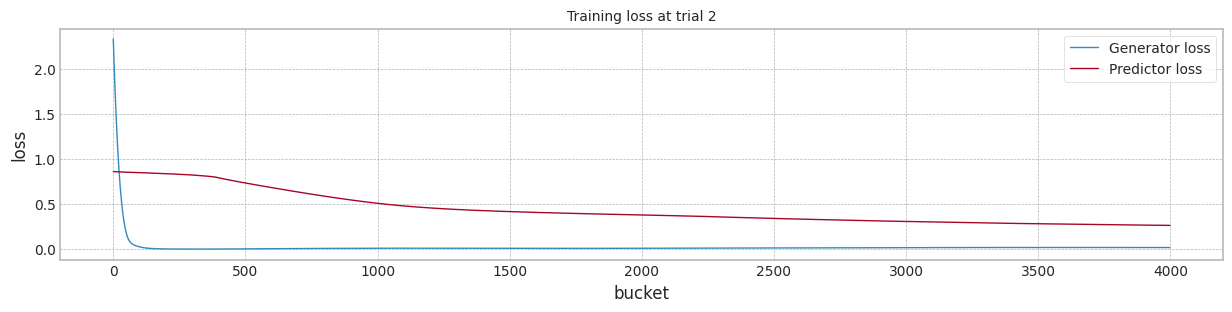

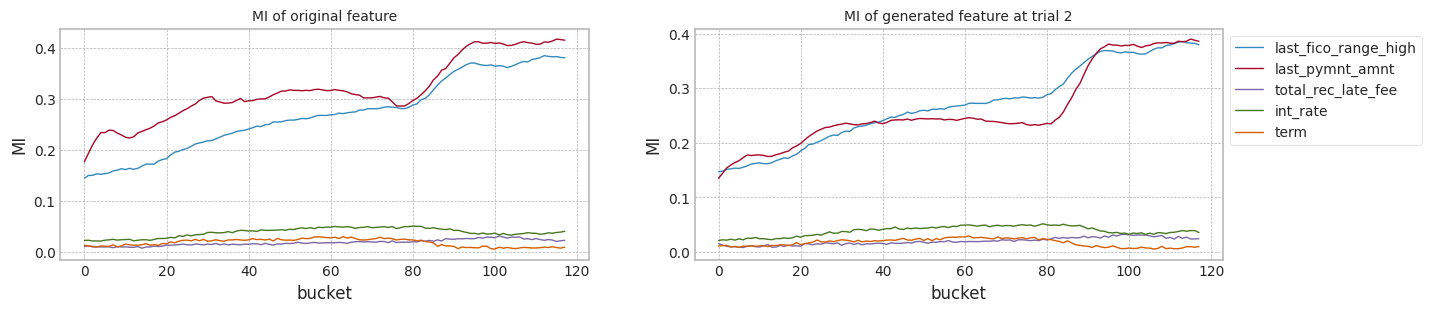

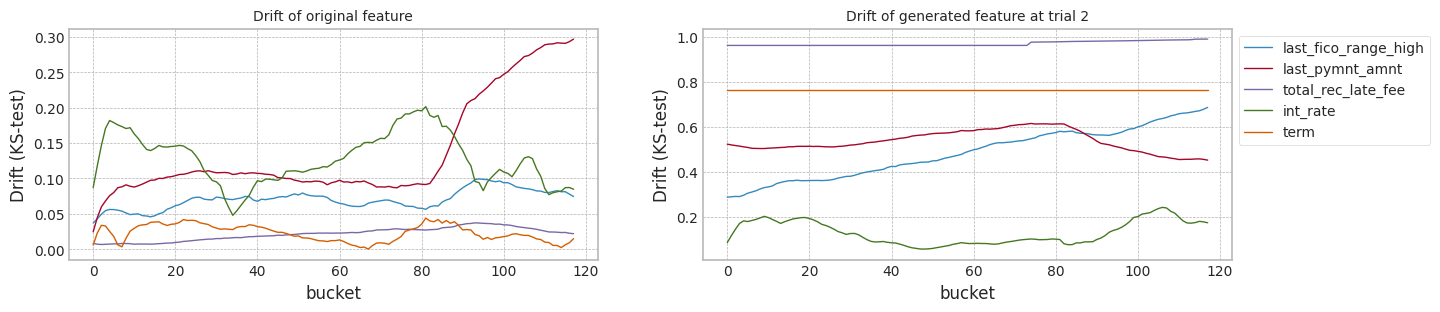

Trial   test_f1   init_f1   mean_f1   last_f1
0   0.0  0.915410  0.915410  0.888584  0.872492
1   1.0  0.915114  0.915114  0.887385  0.870163
2   2.0  0.917039  0.917039  0.893669  0.881695
3  mean  0.915854  0.915854  0.889879  0.874783
4   sem  0.000598  0.000598  0.001926  0.003521

Trial   test_f1   init_f1   mean_f1   last_f1
0   0.0  0.934563  0.934563  0.904156  0.877768
1   1.0  0.915114  0.915114  0.887385  0.870163
2   2.0  0.931920  0.931920  0.958856  0.976317
3  mean  0.927199  0.927199  0.916799  0.908083
4   sem  0.006091  0.006091  0.021579  0.034188

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 130) #np.max(X1['b'])+1)


### #4

In [ ]:
top_columns = list(mi_scores[1:6].index)
print(top_columns)

top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
print(top_columns_index)

X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]

['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
[17, 16, 14, 2, 1]


MI Analysis MI Max 0.31570, Min 0.02189, Mean 0.15207, Std 0.11870
Dataset structure X_train, (100000, 5) X_test, (100000, 5) X_live (1259680, 5)
Truncate 99680 rows from live_set (1259680, 5)
Search MI & Drift...for X_live_set (58, 100000, 5)


100%|██████████| 58/58 [02:47<00:00,  2.89s/it]


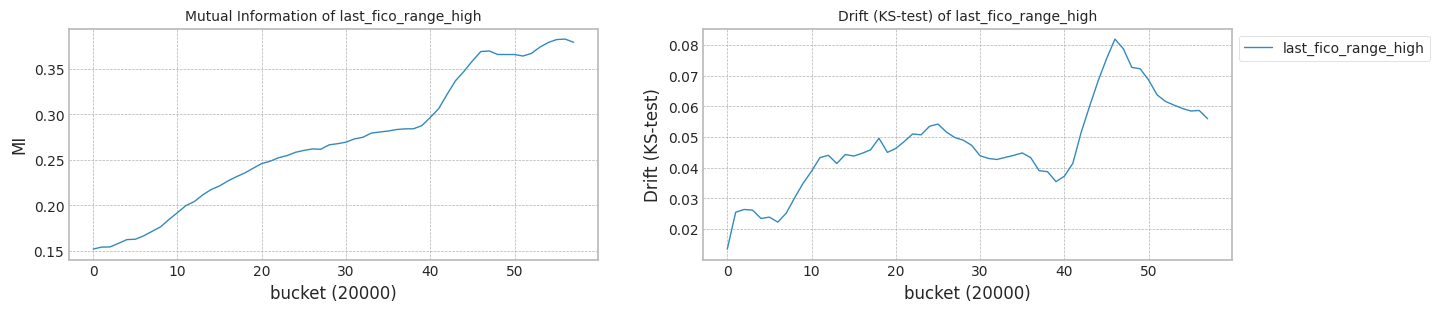

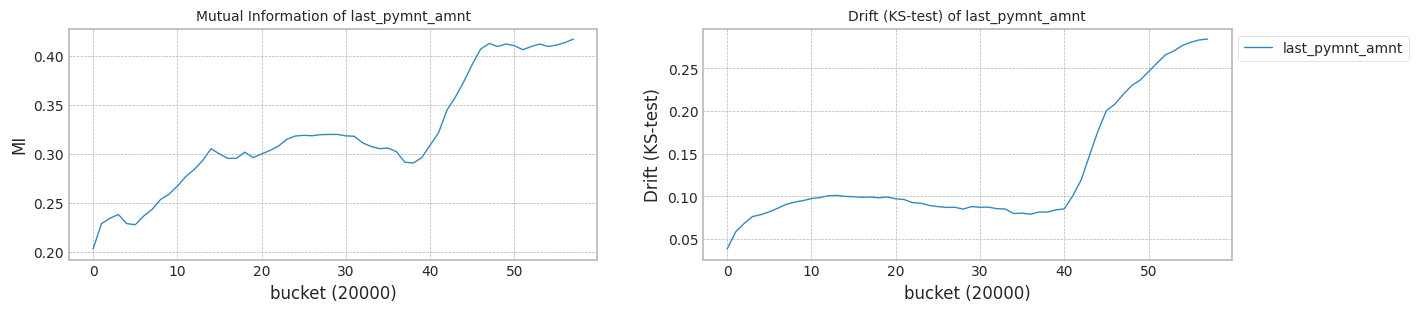

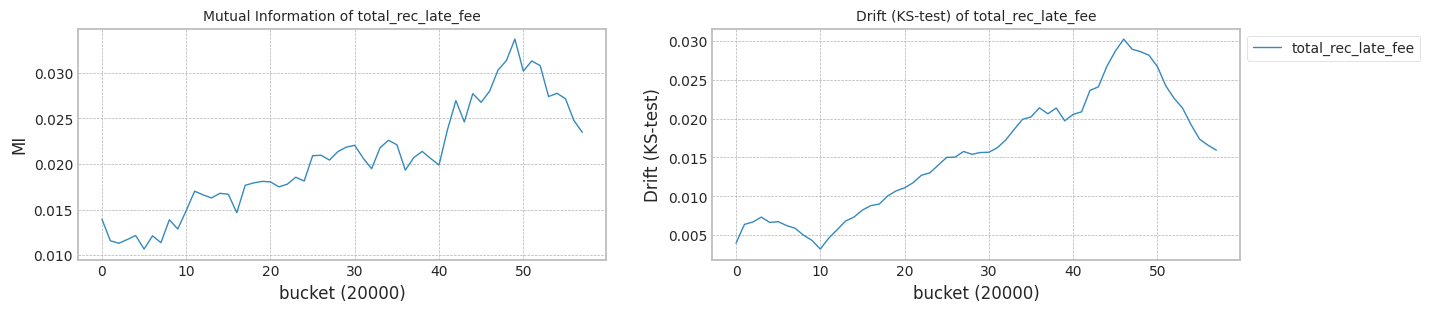

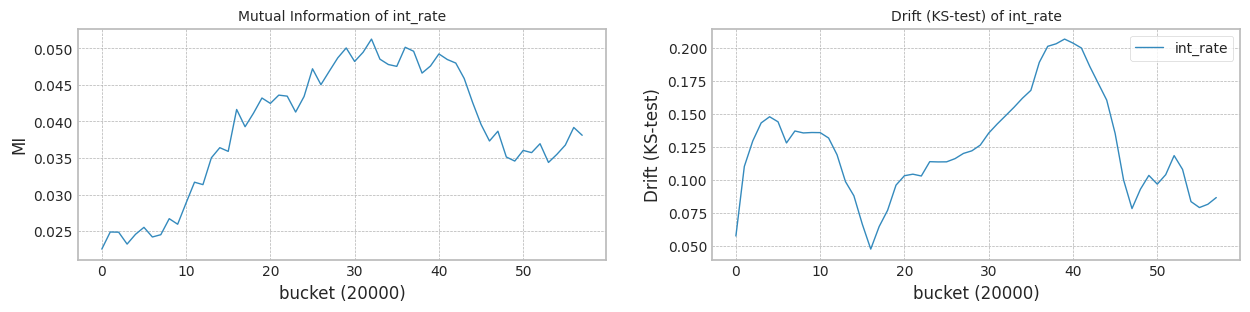

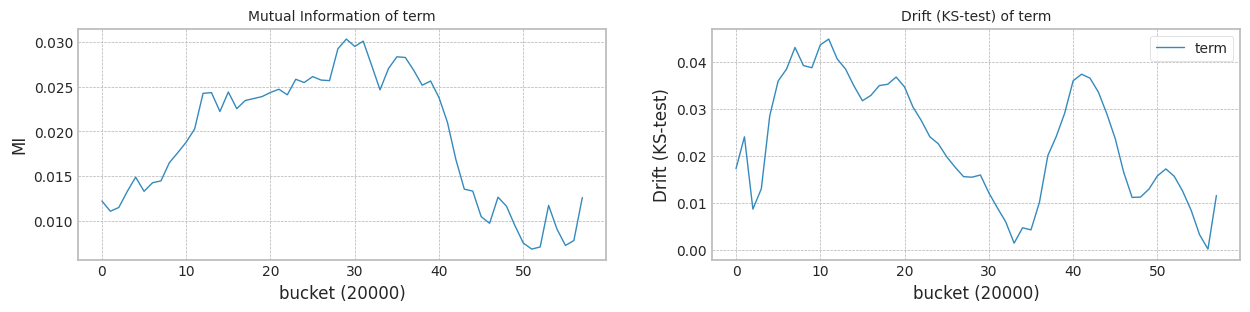

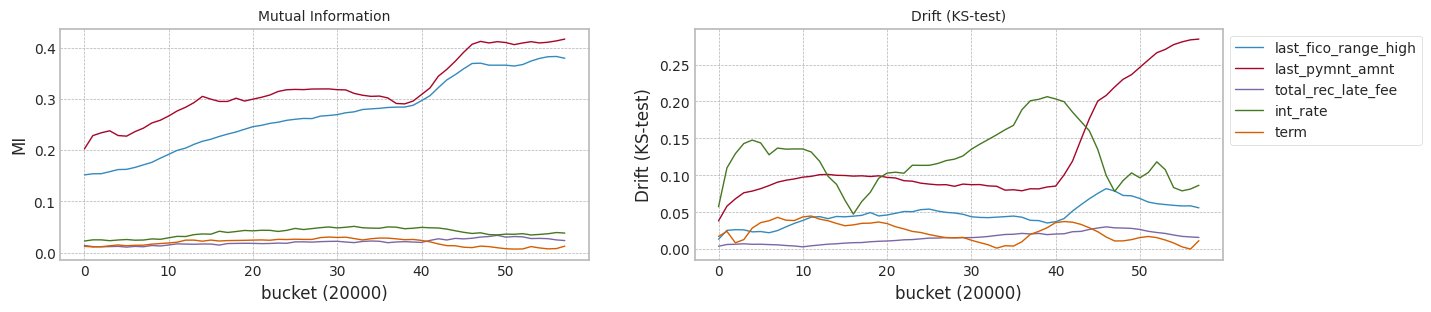

In [ ]:
train_size = 100000
test_size = 20000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)


In [ ]:
bucket_size = 5000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  int_rate  \
0                    0.922353         0.023107            0.000000  0.418593   
1                    0.857647         0.007334            0.000000  0.347201   
2                    0.722353         0.267822            0.000000  0.472008   
3                    0.863529         0.015264            0.000000  0.543400   
4                    0.945882         0.019326            0.000000  0.329224   
...                       ...              ...                 ...       ...   
1279675              0.910588         0.000189            0.052309  0.231638   
1279676              0.851765         0.283658            0.000000  0.231638   
1279677              0.898824         0.235068            0.000000  0.130971   
1279678              0.916471         0.682716            0.000000 -0.005136   
1279679              0.875294         0.264953            0.000000  1.303030   

         term    b  
0         0.0    0  
1         0.0    0  
2         0.0    0  
3         0.0    0  
4         0.0    0  
...       ...  ...  
1279675   0.0  255  
1279676   0.0  255  
1279677   0.0  255  
1279678   0.0  255  
1279679   1.0  255  

[1279680 rows x 6 columns]

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 509.27it/s]


Test f1 score: 0.9149575412499117
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:48<00:00,  2.90s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8885716221713209
######################### Trial 0 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.57it/s]


Test f1 score: 0.9206611570247935
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.75s/it]


mean of drift:
last_fico_range_high    0.246756
last_pymnt_amnt         0.598983
total_rec_late_fee      0.968022
int_rate                0.151128
term                    0.767480
dtype: float64
Mean F1 for all data: 0.941304883728269
######################### Trial 1 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 509.93it/s]


Test f1 score: 0.9216374654557641
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:51<00:00,  2.95s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8998556544512725
######################### Trial 1 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 97.58it/s]


Test f1 score: 0.9379995977358273
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:40<00:00,  2.76s/it]


mean of drift:
last_fico_range_high    0.365446
last_pymnt_amnt         0.655786
total_rec_late_fee      0.965377
int_rate                0.242914
term                    0.753113
dtype: float64
Mean F1 for all data: 0.8978893264843143
######################### Trial 2 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 503.50it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:48<00:00,  2.90s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 2 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 97.92it/s]


Test f1 score: 0.9348616000317442
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:42<00:00,  2.80s/it]


mean of drift:
last_fico_range_high    0.566171
last_pymnt_amnt         0.563957
total_rec_late_fee      0.943638
int_rate                0.129677
term                    0.743058
dtype: float64
Mean F1 for all data: 0.9560815677762226
######################### Trial 3 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 506.49it/s]


Test f1 score: 0.9147909007477721
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:49<00:00,  2.91s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8880984306975221
######################### Trial 3 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:41<00:00, 97.31it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:41<00:00,  2.79s/it]


mean of drift:
last_fico_range_high    0.319288
last_pymnt_amnt         0.588967
total_rec_late_fee      0.992901
int_rate                0.133167
term                    0.751892
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 4 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:08<00:00, 496.47it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:46<00:00,  2.86s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 4 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.31it/s]


Test f1 score: 0.9286564275943371
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:40<00:00,  2.77s/it]


mean of drift:
last_fico_range_high    0.572260
last_pymnt_amnt         0.553841
total_rec_late_fee      0.951093
int_rate                0.147131
term                    0.767480
dtype: float64
Mean F1 for all data: 0.9131820064103829
######################### Trial 5 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 507.72it/s]


Test f1 score: 0.9279314461689522
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:46<00:00,  2.87s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.9167106402574711
######################### Trial 5 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.34it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:40<00:00,  2.76s/it]


mean of drift:
last_fico_range_high    0.115215
last_pymnt_amnt         0.429231
total_rec_late_fee      0.954674
int_rate                0.142884
term                    0.725623
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 6 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 502.28it/s]


Test f1 score: 0.9146502348055051
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:46<00:00,  2.87s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8876512835153842
######################### Trial 6 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.23it/s]


Test f1 score: 0.9335336382920063
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:40<00:00,  2.76s/it]


mean of drift:
last_fico_range_high    0.537570
last_pymnt_amnt         0.573626
total_rec_late_fee      0.925074
int_rate                0.208637
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8982146892983833
######################### Trial 7 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 507.23it/s]


Test f1 score: 0.9147629468334084
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:45<00:00,  2.86s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8879068100979817
######################### Trial 7 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 97.96it/s]


Test f1 score: 0.9381381105320915
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.75s/it]


mean of drift:
last_fico_range_high    0.464167
last_pymnt_amnt         0.595464
total_rec_late_fee      0.967531
int_rate                0.143486
term                    0.752890
dtype: float64
Mean F1 for all data: 0.8966825418080357
######################### Trial 8 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 504.32it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:44<00:00,  2.83s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 8 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.82it/s]


Test f1 score: 0.9345140569990192
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.74s/it]


mean of drift:
last_fico_range_high    0.340451
last_pymnt_amnt         0.542275
total_rec_late_fee      0.943550
int_rate                0.257377
term                    0.754616
dtype: float64
Mean F1 for all data: 0.9132781302681647
######################### Trial 9 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 527.04it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:43<00:00,  2.82s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 9 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.53it/s]


Test f1 score: 0.9370451882127647
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:38<00:00,  2.73s/it]


mean of drift:
last_fico_range_high    0.781144
last_pymnt_amnt         0.588092
total_rec_late_fee      0.958067
int_rate                0.187622
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8920739869444428
######################### Trial 10 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 507.48it/s]


Test f1 score: 0.9145713370852985
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:44<00:00,  2.83s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873127531043788
######################### Trial 10 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.54it/s]


Test f1 score: 0.9201969797172106
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.74s/it]


mean of drift:
last_fico_range_high    0.251969
last_pymnt_amnt         0.522007
total_rec_late_fee      0.967625
int_rate                0.259335
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8879570921281809
######################### Trial 11 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 503.49it/s]


Test f1 score: 0.9228716070896799
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:44<00:00,  2.84s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.9029031054999391
######################### Trial 11 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.06it/s]


Test f1 score: 0.9356688762697676
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.75s/it]


mean of drift:
last_fico_range_high    0.590916
last_pymnt_amnt         0.707133
total_rec_late_fee      0.948811
int_rate                0.225389
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8948943429677537
######################### Trial 12 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 509.86it/s]


Test f1 score: 0.9215644298065048
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:44<00:00,  2.83s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.9003388156629475
######################### Trial 12 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.91it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.74s/it]


mean of drift:
last_fico_range_high    0.523264
last_pymnt_amnt         0.415303
total_rec_late_fee      0.932955
int_rate                0.121895
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 13 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 509.70it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:45<00:00,  2.85s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8872992380679643
######################### Trial 13 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.74it/s]


Test f1 score: 0.9331792711587756
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.75s/it]


mean of drift:
last_fico_range_high    0.799180
last_pymnt_amnt         0.697253
total_rec_late_fee      0.962435
int_rate                0.236141
term                    0.767480
dtype: float64
Mean F1 for all data: 0.890663482055416
######################### Trial 14 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 512.31it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:47<00:00,  2.89s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 14 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.51it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.76s/it]


mean of drift:
last_fico_range_high    0.322708
last_pymnt_amnt         0.480926
total_rec_late_fee      0.969155
int_rate                0.148509
term                    0.737679
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 15 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 503.11it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:46<00:00,  2.87s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873045435751417
######################### Trial 15 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.16it/s]


Test f1 score: 0.9372986962643727
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.74s/it]


mean of drift:
last_fico_range_high    0.226214
last_pymnt_amnt         0.821907
total_rec_late_fee      0.950466
int_rate                0.166086
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8918401864946992
######################### Trial 16 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 509.84it/s]


Test f1 score: 0.927967811351206
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:45<00:00,  2.86s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.917230935499608
######################### Trial 16 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 99.65it/s] 


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:38<00:00,  2.74s/it]


mean of drift:
last_fico_range_high    0.442276
last_pymnt_amnt         0.590011
total_rec_late_fee      0.964097
int_rate                0.188357
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 17 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 502.33it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:47<00:00,  2.89s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873046327146397
######################### Trial 17 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 99.33it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.75s/it]


mean of drift:
last_fico_range_high    0.544878
last_pymnt_amnt         0.734690
total_rec_late_fee      0.945927
int_rate                0.157538
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 18 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 502.18it/s]


Test f1 score: 0.9145831185112422
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:46<00:00,  2.86s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.8873029740733172
######################### Trial 18 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.95it/s]


Test f1 score: 0.9378897936126628
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:39<00:00,  2.76s/it]


mean of drift:
last_fico_range_high    0.499277
last_pymnt_amnt         0.709181
total_rec_late_fee      0.978482
int_rate                0.144082
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8940802557231109
######################### Trial 19 for Normal model ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 500.07it/s]


Test f1 score: 0.9252901930553321
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:46<00:00,  2.87s/it]


mean of drift:
last_fico_range_high    0.067513
last_pymnt_amnt         0.127393
total_rec_late_fee      0.021608
int_rate                0.129588
term                    0.023087
dtype: float64
Mean F1 for all data: 0.909488900227719
######################### Trial 19 for Drift tolerant model ###########################
cuda:0


100%|██████████| 4000/4000 [00:40<00:00, 98.89it/s]


Test f1 score: 0.9308162032791285
X_live.shape (1259680, 6)
Truncate 99680 rows from live_set (1259680, 6)
Search MI & Drift...for X_live_set torch.Size([58, 100000, 6])


100%|██████████| 58/58 [02:40<00:00,  2.76s/it]


mean of drift:
last_fico_range_high    0.462630
last_pymnt_amnt         0.616485
total_rec_late_fee      0.955856
int_rate                0.125532
term                    0.767480
dtype: float64
Mean F1 for all data: 0.8958666543493505


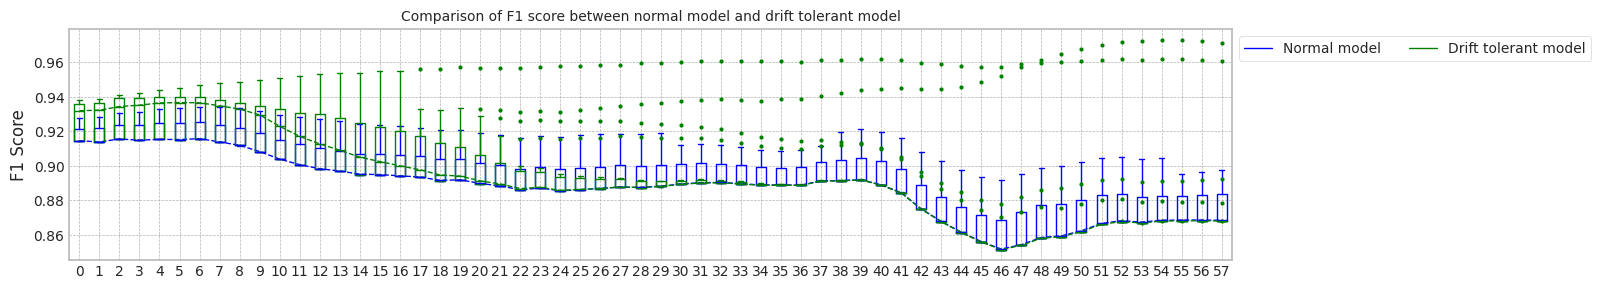

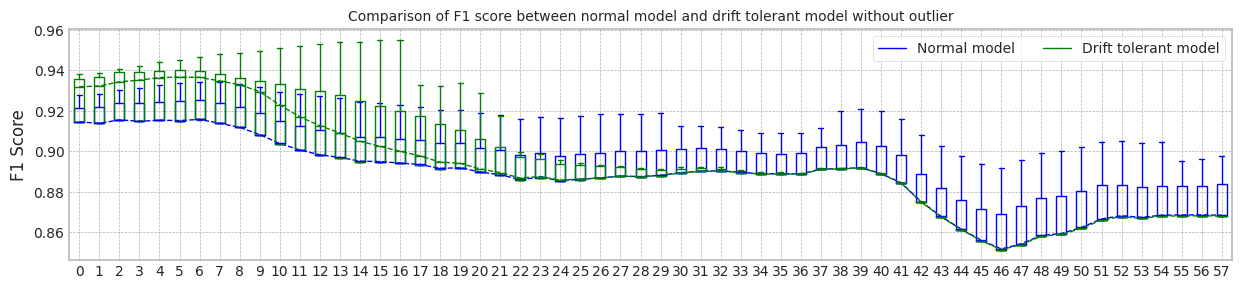

max_mean_trial= -15


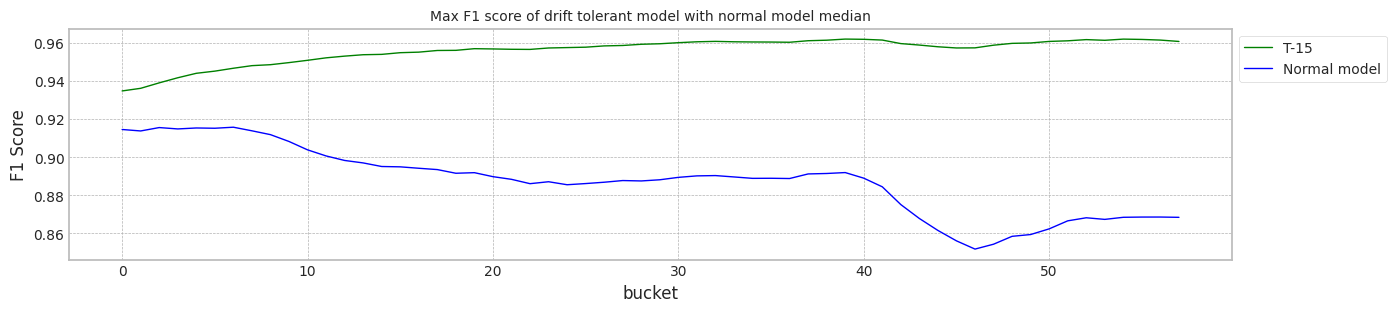

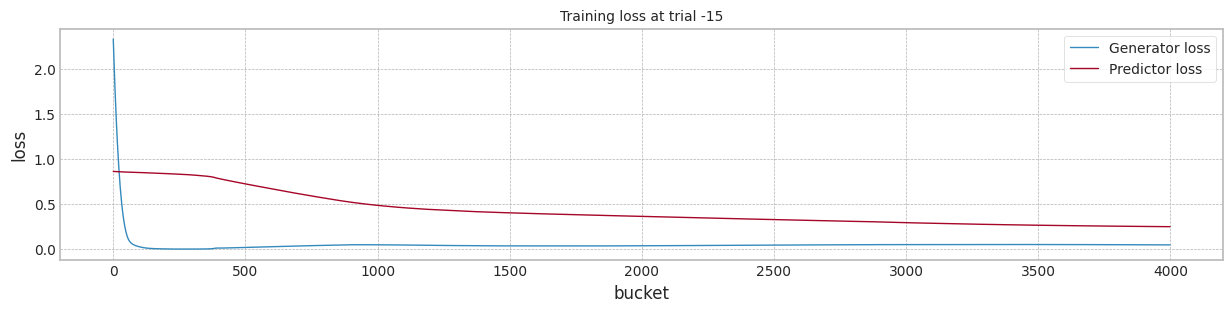

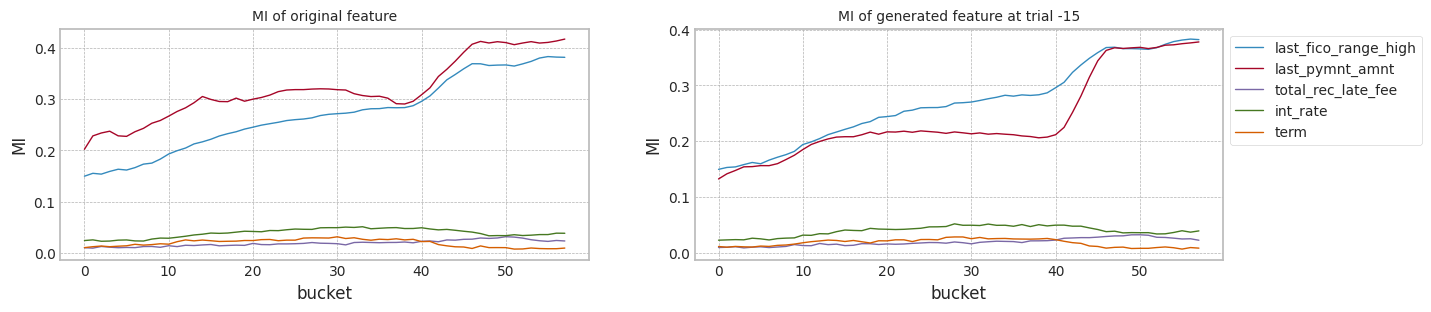

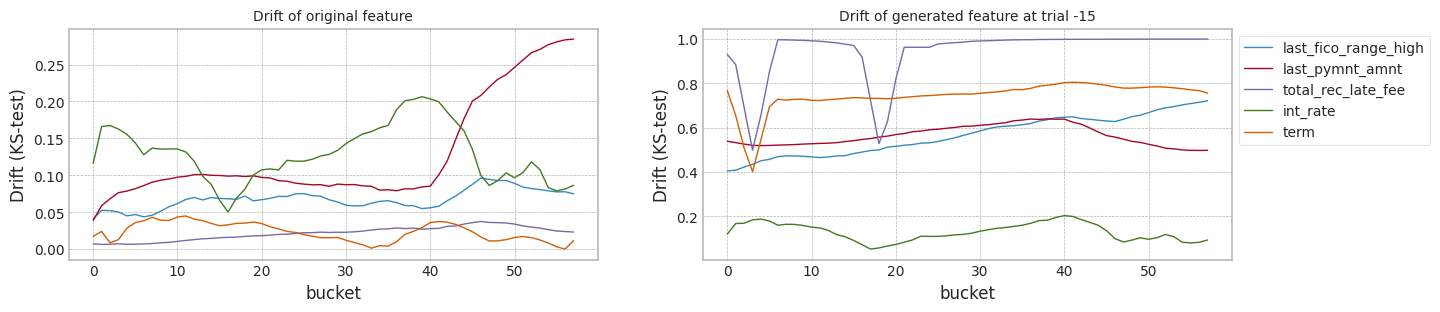

Trial   test_f1   init_f1   mean_f1   last_f1
0    0.0  0.914958  0.914958  0.888572  0.870629
1    1.0  0.921637  0.921637  0.899856  0.883739
2    2.0  0.914583  0.914583  0.887303  0.868055
3    3.0  0.914791  0.914791  0.888098  0.870261
4    4.0  0.914583  0.914583  0.887303  0.868055
5    5.0  0.927931  0.927931  0.916711  0.908180
6    6.0  0.914650  0.914650  0.887651  0.868872
7    7.0  0.914763  0.914763  0.887907  0.869040
8    8.0  0.914583  0.914583  0.887303  0.868055
9    9.0  0.914583  0.914583  0.887303  0.868055
10  10.0  0.914571  0.914571  0.887313  0.868102
11  11.0  0.922872  0.922872  0.902903  0.888822
12  12.0  0.921564  0.921564  0.900339  0.884167
13  13.0  0.914583  0.914583  0.887299  0.868055
14  14.0  0.914583  0.914583  0.887303  0.868055
15  15.0  0.914583  0.914583  0.887305  0.868055
16  16.0  0.927968  0.927968  0.917231  0.908806
17  17.0  0.914583  0.914583  0.887305  0.868068
18  18.0  0.914583  0.914583  0.887303  0.868055
19  19.0  0.925290  0.925290  0.909489  0.897550
20  mean  0.917612  0.917612  0.893590  0.876534
21   sem  0.001095  0.001095  0.002315  0.003100

Trial   test_f1   init_f1   mean_f1   last_f1
0  -19.0  0.920661  0.920661  0.941305  0.971019
1  -17.0  0.938000  0.938000  0.897889  0.868055
2  -15.0  0.934862  0.934862  0.956082  0.960854
3  -13.0  0.914583  0.914583  0.887303  0.868055
4  -11.0  0.928656  0.928656  0.913182  0.878441
5   -9.0  0.914583  0.914583  0.887303  0.868055
6   -7.0  0.933534  0.933534  0.898215  0.868065
7   -5.0  0.938138  0.938138  0.896683  0.868055
8   -3.0  0.934514  0.934514  0.913278  0.892618
9   -1.0  0.937045  0.937045  0.892074  0.868055
10   1.0  0.920197  0.920197  0.887957  0.868055
11   3.0  0.935669  0.935669  0.894894  0.868055
12   5.0  0.914583  0.914583  0.887303  0.868055
13   7.0  0.933179  0.933179  0.890663  0.868055
14   9.0  0.914583  0.914583  0.887303  0.868055
15  11.0  0.937299  0.937299  0.891840  0.868055
16  13.0  0.914583  0.914583  0.887303  0.868055
17  15.0  0.914583  0.914583  0.887303  0.868055
18  17.0  0.937890  0.937890  0.894080  0.868055
19  19.0  0.930816  0.930816  0.895867  0.868055
20  mean  0.927398  0.927398  0.899391  0.879591
21   sem  0.002219  0.002219  0.004174  0.006740

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 260)